In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')
import h5py
#
#import operator
import math
import random
import numpy
import scipy
#import scipy.optimize as spo
from scipy import interpolate
import scipy.constants
import itertools
import sys
#import scipy.optimize as spo
import os
#import operator
#from PIL import Image as ipp
import multiprocessing as mpp
import time
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
#import json
#import pickle
#

import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
os.environ['PROJ_LIB'] = '{}/anaconda3/share/proj'.format(os.getenv('HOME'))
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#

#import ANSStools as atp
from yodiipy import ANSStools as atp
import nETAS
#
import contours2kml
import globalETAS as gep

#import global_etas_auto as ggep

from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

In [8]:
# how do we reproduce ravel()? We want to map a small sub-array into a big array.
from nETAS import nd_to_ravel_index
# def nd_to_ravel_index(ks, dims):
#     '''
#     # convert n-D array indices of an array A to the index of A.ravel()
#     '''
#     #
#     # start by just coding this for scalars; we'll work on vectorization later
#     # we have two reverse() operations here, so there is probably a one-step shorter solution.
#     # get dimension multipliers; number of elements to skip to get the next value on an axis.
#     ns_cp = numpy.cumprod(dims[::-1])
#     #
#     return numpy.dot(ks, numpy.append((ns_cp[0:-1])[::-1], [1])) 
#
# test:
# set up some n-d arrays; see if A[j,k,l] == A.ravel(k(j,k,l))
#
dims = [5, 10, 11]
A = numpy.random.randint(0,1000, size=numpy.prod(dims))
A.shape = dims
#
for _ in range(25):
    ks = [numpy.random.randint(0,n) for n in dims]
    k_r = nd_to_ravel_index(ks, dims)
    n_error = 0
    #
    print('ks: {}, k_r: {}, z={}/{}'.format(ks, k_r, A[tuple(ks)], A.ravel()[k_r]))
    if not A[tuple(ks)] == A.ravel()[k_r]:
        print('Error!')
        n_error+=1
    #
if n_error==0:
    print('Success!')
else:
    print('Errors...')

ks: [2, 5, 0], k_r: 275, z=124/124
ks: [2, 4, 2], k_r: 266, z=466/466
ks: [3, 5, 5], k_r: 390, z=589/589
ks: [1, 7, 1], k_r: 188, z=581/581
ks: [0, 4, 3], k_r: 47, z=126/126
ks: [3, 0, 8], k_r: 338, z=92/92
ks: [2, 9, 5], k_r: 324, z=504/504
ks: [0, 6, 6], k_r: 72, z=553/553
ks: [3, 2, 9], k_r: 361, z=133/133
ks: [4, 8, 2], k_r: 530, z=208/208
ks: [0, 4, 1], k_r: 45, z=808/808
ks: [1, 5, 6], k_r: 171, z=920/920
ks: [3, 8, 4], k_r: 422, z=344/344
ks: [4, 5, 5], k_r: 500, z=949/949
ks: [4, 2, 8], k_r: 470, z=227/227
ks: [1, 7, 7], k_r: 194, z=693/693
ks: [2, 2, 3], k_r: 245, z=358/358
ks: [3, 2, 9], k_r: 361, z=133/133
ks: [0, 7, 3], k_r: 80, z=290/290
ks: [1, 6, 8], k_r: 184, z=888/888
ks: [3, 6, 5], k_r: 401, z=971/971
ks: [0, 3, 8], k_r: 41, z=236/236
ks: [4, 8, 3], k_r: 531, z=121/121
ks: [4, 4, 7], k_r: 491, z=612/612
ks: [3, 2, 2], k_r: 354, z=379/379
Success!


In [9]:
print(A.shape)

(5, 10, 11)


In [10]:
# let's just get a catalog and pull an earthquake out of it.
n_cpu=None
#
lat0 = 35.705
lon0 = -117.506
#
#ll_sacramento = (lon0, lat0)

#m0 = 7.8

d_lat=2.
d_lon=2.
#
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]
#
to_dt = dtm.datetime(2019,7,6, tzinfo=tzutc)
eq_prams = {'do_recarray': True, 'D_fract': 1.5,
               't_0':dtm.datetime(1990, 1, 1, 0, 0, 0, tzinfo=tzutc),
               't_now':to_dt, 't_future':None ,
               'lats': lats, 'p_cat': 1.1, 'b1': 1.0, 'mc': 2.5, 'q_cat': 1.5,
               'p_etas':1.1, 'q_etas':1.5,
               'lons': lons, 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
               'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76, 'etas_range_padding':1.5,
            'etas_range_factor':30.0, 'ab_ratio_expon':.25 }
eq_prams['mc'] = 6.7
eq_prams['t0'] = dtm.datetime(2019,6,20, 0,0,0,0, tzinfo=pytz.timezone('UTC'))
#

mycat = atp.cat_from_anss_comcat(lon=lons, lat=lats, minMag=2.5,
                        dates0=[dtm.datetime(2005,1,1, tzinfo=pytz.timezone('UTC')), 
                                dtm.datetime.now(pytz.timezone('UTC'))],
                            Nmax=None, fout=None, rec_array=True)
#                        dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, fout=None, rec_array=True)

mycat = gep.make_ETAS_catalog_mpp(incat=mycat, n_cpu=n_cpu)
#

*** DEBUG:   https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2005-01-01%2000:00:00&endtime=2019-12-14%2007:43:01&minmagnitude=2.5&minlatitude=33.705&maxlatitude=37.705&minlongitude=-119.506&maxlongitude=-115.506&eventtype=earthquake&orderby=time
etas_prams:  {'incat': None, 'lats': [32.0, 38.0], 'lons': [-117.0, -114.0], 'mc': 2.5, 'date_range': ['1990-1-1', None], 'D_fract': 1.5, 'd_lambda': 1.76, 'd_tau': 2.28, 'fit_factor': 1.5, 'p': 1.1, 'q': 1.5, 'dmstar': 1.0, 'b1': 1.0, 'b2': 1.5, 'do_recarray': False}
results fetched.


In [11]:
for rw in mycat:
    if rw['mag']>7.0:
        eq_ms = rw
    #
#
print('mainshock: ', eq_ms)

mainshock:  ('2019-07-06T03:19:53.040000', 35.7695, -117.5993333, 7.1, 8., 737246.13880833, 61.65950019, 1277.03847158, 1.40581446e-05, 18.62087137, 165.68091867, 0.00150686, 1., 1.1, 1.5, 26.80175629, [0.0882772 , 0.05423607], [[ 0.818203  ,  0.57492943], [-0.57492943,  0.818203  ]], 3407.)


In [12]:
eq = gep.Earthquake(eq_ms)

In [13]:
print(eq.local_intensity(lon=-117., lat=35.) )
print(eq.local_intensity(lon=-117., lat=34.) )

5.693993178401455e-13
4.628758706879698e-13


In [14]:
eq.t_0, eq.t_1, eq.t_2

(165.68091866556017, 737407.3218350532, None)

In [15]:
ts = numpy.linspace(eq.t_1, eq.t_1+100, 100)

#ts[20] = None

In [16]:
#orates = eq.omori_rate(t=ts)
# this works, but eq.orate() does not; eq.orate() fails on some sort of validation (.any(), .all() reference)
orates = 1./(eq.tau*(eq.t_0 + ts))

print('** orates: ', orates)

** orates:  [0.00089975 0.00089975 0.00089975 0.00089975 0.00089975 0.00089974
 0.00089974 0.00089974 0.00089974 0.00089974 0.00089974 0.00089974
 0.00089974 0.00089973 0.00089973 0.00089973 0.00089973 0.00089973
 0.00089973 0.00089973 0.00089973 0.00089972 0.00089972 0.00089972
 0.00089972 0.00089972 0.00089972 0.00089972 0.00089972 0.00089972
 0.00089971 0.00089971 0.00089971 0.00089971 0.00089971 0.00089971
 0.00089971 0.00089971 0.0008997  0.0008997  0.0008997  0.0008997
 0.0008997  0.0008997  0.0008997  0.0008997  0.00089969 0.00089969
 0.00089969 0.00089969 0.00089969 0.00089969 0.00089969 0.00089969
 0.00089968 0.00089968 0.00089968 0.00089968 0.00089968 0.00089968
 0.00089968 0.00089968 0.00089967 0.00089967 0.00089967 0.00089967
 0.00089967 0.00089967 0.00089967 0.00089967 0.00089966 0.00089966
 0.00089966 0.00089966 0.00089966 0.00089966 0.00089966 0.00089966
 0.00089965 0.00089965 0.00089965 0.00089965 0.00089965 0.00089965
 0.00089965 0.00089965 0.00089964 0.00089964 0.0008

In [17]:
print('** orates: ', orates)

** orates:  [0.00089975 0.00089975 0.00089975 0.00089975 0.00089975 0.00089974
 0.00089974 0.00089974 0.00089974 0.00089974 0.00089974 0.00089974
 0.00089974 0.00089973 0.00089973 0.00089973 0.00089973 0.00089973
 0.00089973 0.00089973 0.00089973 0.00089972 0.00089972 0.00089972
 0.00089972 0.00089972 0.00089972 0.00089972 0.00089972 0.00089972
 0.00089971 0.00089971 0.00089971 0.00089971 0.00089971 0.00089971
 0.00089971 0.00089971 0.0008997  0.0008997  0.0008997  0.0008997
 0.0008997  0.0008997  0.0008997  0.0008997  0.00089969 0.00089969
 0.00089969 0.00089969 0.00089969 0.00089969 0.00089969 0.00089969
 0.00089968 0.00089968 0.00089968 0.00089968 0.00089968 0.00089968
 0.00089968 0.00089968 0.00089967 0.00089967 0.00089967 0.00089967
 0.00089967 0.00089967 0.00089967 0.00089967 0.00089966 0.00089966
 0.00089966 0.00089966 0.00089966 0.00089966 0.00089966 0.00089966
 0.00089965 0.00089965 0.00089965 0.00089965 0.00089965 0.00089965
 0.00089965 0.00089965 0.00089964 0.00089964 0.0008

In [18]:
print(numpy.round(1.23456789,4))

1.2346


/Users/myoder96/Codes/globalETAS/globalETAS.py:1539: RuntimeWarning: invalid value encountered in true_divide
  R_primes = Rs_sph * (numpy.linalg.norm(dxs_dys_prime, axis=1)/numpy.linalg.norm([dxs.ravel(),dys.ravel()], axis=0)).reshape(Rs_sph.shape)
/Users/myoder96/Codes/globalETAS/globalETAS.py:1539: RuntimeWarning: invalid value encountered in true_divide
  R_primes = Rs_sph * (numpy.linalg.norm(dxs_dys_prime, axis=1)/numpy.linalg.norm([dxs.ravel(),dys.ravel()], axis=0)).reshape(Rs_sph.shape)


li_shape[0]: (100, 5, 5)
li_shape[1]: (100, 25)
li_shape[2]: (100, 25)
(itr==mgr).all() False
******


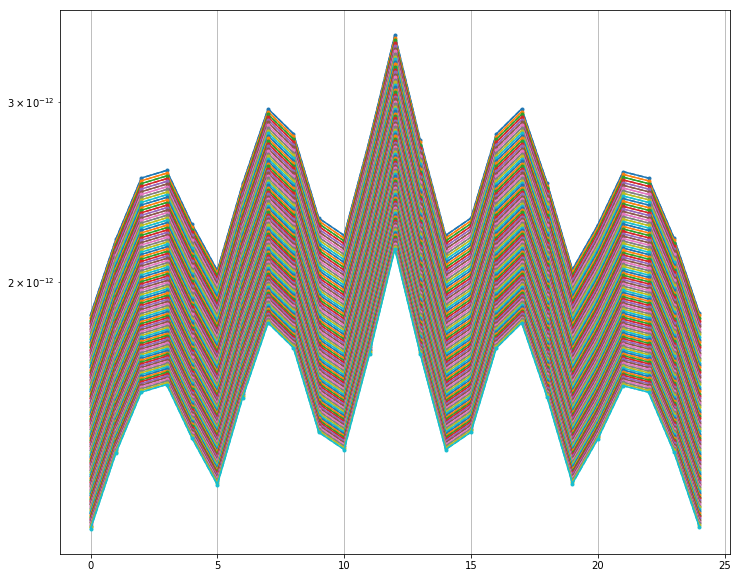

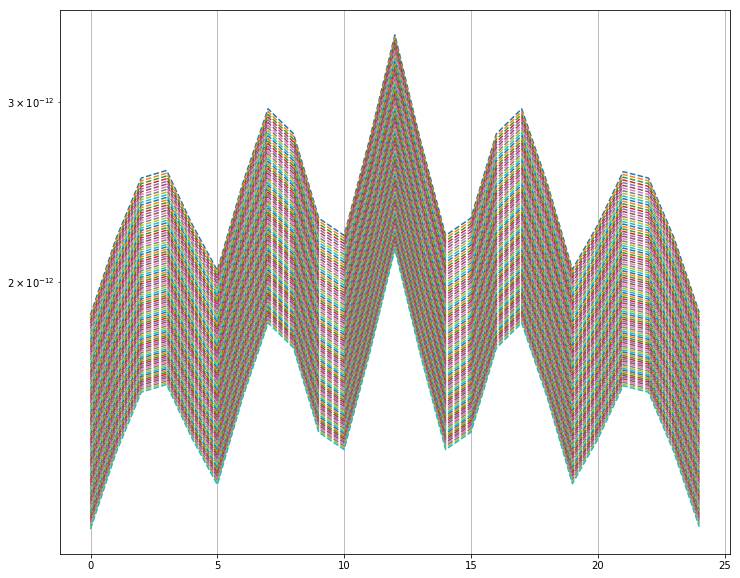

In [19]:
# create three versions of lons, lats:
# 1) itertools
# 2) meshgrid
# 3) meshgrid, then raveled to look like itertools
#
lon_dim = numpy.linspace(eq.lon-2., eq.lon+2., 5)
lat_dim  = numpy.linspace(eq.lat-2., eq.lat+2., 5)
#
# note: we might want to transpose these. meshgrid() and itertools.product() basically 
#. create transposed versinos of the same data product.
#
lons_mg, lats_mg = numpy.meshgrid(lon_dim, lat_dim)
LL_i = numpy.array([[b,a] for a,b in itertools.product(lat_dim, lon_dim)])
LL_r = numpy.array([lons_mg.ravel(), lats_mg.ravel()]).T

#
# NOTE: I think this is the right way to compare 2D and ravel()ed data.
# TODO: figure these out...
local_intensities_mgs = eq.local_intensities(ts=ts, lons=lons_mg, lats=lats_mg)
local_intensities_mgr = eq.local_intensities(ts=ts, lons=lons_mg.T.reshape(-1), lats=lats_mg.T.reshape(-1))
# this might all be wrong (axes not alligned correctly) now...
local_intensities_itr = eq.local_intensities(ts=ts, lons=LL_i[:,0], lats=LL_i[:,1])

for k, li in enumerate([local_intensities_mgs, local_intensities_mgr, local_intensities_itr]):
    print('li_shape[{}]: {}'.format(k, li.shape))
#print('li_shapes: ', local_intensities.shape)
#print('** ', local_intensities[0][0:20])
#
#print('mgs==mgr: ', local_intensities_mgs.reshape(local_intensities_mgr.shape)==local_intensities_mgr)
#print('mgs==itr: ',  (local_intensities_mgs==local_intensities_itr.reshape(-1, 5,5)))
#
# these basically are equal, with a nan issue in the middle.
#print('itr==mgr: ', (local_intensities_itr==local_intensities_mgr))
print('(itr==mgr).all()', (local_intensities_itr==local_intensities_mgr).all())
print('******')

# local_intensities_mgs.reshape(local_intensities_mgr.shape)==local_intensities_mgr
#
fg = plt.figure(figsize=(12,10))
ax = plt.gca()
ax.grid()
ax.set_yscale('log')
#
for k, (rw1, rw2) in enumerate(zip(local_intensities_mgs, local_intensities_mgr) ):
    #if k%10!=0:
    #    continue
    #if k==0: continue
    #
    ln, = ax.plot(rw1.T.ravel(), ls='-')
    clr = ln.get_color()
    ax.plot(rw2.ravel(), ls='--', color=clr, marker='.')
    #

# #
fg = plt.figure(figsize=(12,10))
ax = plt.gca()
ax.grid()
ax.set_yscale('log')
#
for k, (rw1, rw2) in enumerate(zip(local_intensities_mgs, local_intensities_mgr) ):
    #if k%10!=0:
    #    continue
    #
    ln, = ax.plot(rw1.reshape(rw2.shape)[0], ls='-')
    clr = ln.get_color()
    ax.plot(rw2.ravel(), ls='--', color=clr)
    #

# #

In [20]:
print('** ', local_intensities_mgs[0].T.ravel())
print('\n')
print('** ', local_intensities_mgr[0])

print('\n\n')

print('** ', local_intensities_mgs[0])
print('\n')
print('** ', local_intensities_mgr[0].reshape((5,5)).T)

**  [1.85500916e-12 2.20104446e-12 2.52567954e-12 2.56967471e-12
 2.27699343e-12 2.05043295e-12 2.49534180e-12 2.95262668e-12
 2.79185775e-12 2.30716624e-12 2.21932712e-12 2.75397322e-12
 3.48788749e-12 2.75397322e-12 2.21932712e-12 2.30793827e-12
 2.79029977e-12 2.95262668e-12 2.49903393e-12 2.05512965e-12
 2.27231313e-12 2.56250979e-12 2.52567954e-12 2.20816798e-12
 1.86478737e-12]


**  [1.85500916e-12 2.20104446e-12 2.52567954e-12 2.56967471e-12
 2.27699343e-12 2.05043295e-12 2.49534180e-12 2.95262668e-12
 2.79185775e-12 2.30716624e-12 2.21932712e-12 2.75397322e-12
 3.48788749e-12 2.75397322e-12 2.21932712e-12 2.30793827e-12
 2.79029977e-12 2.95262668e-12 2.49903393e-12 2.05512965e-12
 2.27231313e-12 2.56250979e-12 2.52567954e-12 2.20816798e-12
 1.86478737e-12]



**  [[1.85500916e-12 2.05043295e-12 2.21932712e-12 2.30793827e-12
  2.27231313e-12]
 [2.20104446e-12 2.49534180e-12 2.75397322e-12 2.79029977e-12
  2.56250979e-12]
 [2.52567954e-12 2.95262668e-12 3.48788749e-12 2.95262668

In [21]:
for rw1, rw2 in zip(local_intensities_mgs, local_intensities_mgr):
    #print('** ', (rw1.ravel()==rw2))
    #print('** ', (rw1.T.ravel()-rw2)/(rw1.ravel()+rw2))
    #
    print('*** ', rw1, ' *** ', rw2)
    #
    break

# for rw1, rw2 in zip(local_intensities_itr, local_intensities_mgr):
#     #print('** ', (rw1==rw2)),
#     #print('** ', [(x1-x2)/(x1+x2) for x1, x2 in zip(rw1, rw2)])
#     print('** ', [(x1, x2) for x1, x2 in zip(rw1, rw2) if x1!=x2])
#


***  [[1.85500916e-12 2.05043295e-12 2.21932712e-12 2.30793827e-12
  2.27231313e-12]
 [2.20104446e-12 2.49534180e-12 2.75397322e-12 2.79029977e-12
  2.56250979e-12]
 [2.52567954e-12 2.95262668e-12 3.48788749e-12 2.95262668e-12
  2.52567954e-12]
 [2.56967471e-12 2.79185775e-12 2.75397322e-12 2.49903393e-12
  2.20816798e-12]
 [2.27699343e-12 2.30716624e-12 2.21932712e-12 2.05512965e-12
  1.86478737e-12]]  ***  [1.85500916e-12 2.20104446e-12 2.52567954e-12 2.56967471e-12
 2.27699343e-12 2.05043295e-12 2.49534180e-12 2.95262668e-12
 2.79185775e-12 2.30716624e-12 2.21932712e-12 2.75397322e-12
 3.48788749e-12 2.75397322e-12 2.21932712e-12 2.30793827e-12
 2.79029977e-12 2.95262668e-12 2.49903393e-12 2.05512965e-12
 2.27231313e-12 2.56250979e-12 2.52567954e-12 2.20816798e-12
 1.86478737e-12]


In [22]:
A = numpy.random.random((2,2))
print(A)
#

A_prime = numpy.dot(numpy.array([lons_mg-eq.lon, lats_mg-eq.lat]).T, A)
A_prime_2 = numpy.dot(numpy.array([(lons_mg-eq.lon).ravel(), (lats_mg-eq.lat).ravel()]).T, A)
#
print('A_prime shape: ', A_prime.shape)
print('A_prime_2 shape: ', A_prime_2.shape)
print(A_prime)
print('normed_1: ', numpy.linalg.norm(A_prime, axis=-1).T.ravel())
print('normed_2: ', numpy.linalg.norm(A_prime_2, axis=-1))
print('*** ***')

[[0.59829593 0.30899454]
 [0.26579295 0.81697627]]
A_prime shape:  (5, 5, 2)
A_prime_2 shape:  (25, 2)
[[[-1.72817777 -2.25194162]
  [-1.46238482 -1.43496535]
  [-1.19659187 -0.61798909]
  [-0.93079892  0.19898718]
  [-0.66500596  1.01596345]]

 [[-1.12988184 -1.94294708]
  [-0.86408889 -1.12597081]
  [-0.59829593 -0.30899454]
  [-0.33250298  0.50798172]
  [-0.06671003  1.32495799]]

 [[-0.5315859  -1.63395253]
  [-0.26579295 -0.81697627]
  [ 0.          0.        ]
  [ 0.26579295  0.81697627]
  [ 0.5315859   1.63395253]]

 [[ 0.06671003 -1.32495799]
  [ 0.33250298 -0.50798172]
  [ 0.59829593  0.30899454]
  [ 0.86408889  1.12597081]
  [ 1.12988184  1.94294708]]

 [[ 0.66500596 -1.01596345]
  [ 0.93079892 -0.19898718]
  [ 1.19659187  0.61798909]
  [ 1.46238482  1.43496535]
  [ 1.72817777  2.25194162]]]
normed_1:  [2.83863338 2.24759345 1.71825041 1.32663631 1.21425477 2.0488277
 1.41931669 0.8591252  0.60712739 0.95183114 1.34675262 0.67337631
 0.         0.67337631 1.34675262 0.9518311

In [23]:
lons_mg, lats_mg = numpy.meshgrid(numpy.linspace(eq.lon-2., eq.lon+2., 20), numpy.linspace(eq.lat-2., eq.lat+2., 20))
#lons_mg = numpy.array(lons_mg)
#lats_mg = numpy.array(lats_mg)
print('** shapes: lons:: {}, lats:: {}'.format(lons_mg.shape, lats_mg.shape))
#

local_intensities_mg = eq.local_intensities(ts=ts, lons=lons_mg, lats=lats_mg)
#
print('li_shapes: ', local_intensities_mg.shape)
#print('** ', local_intensities_mgr[0][0:20])
#print('** ', local_intensities_mg[0][0:20])

** shapes: lons:: (20, 20), lats:: (20, 20)
li_shapes:  (100, 20, 20)


In [24]:
print('*** ', local_intensities_mg.shape)

***  (100, 20, 20)


*** local_inte:  (100, 5, 5)
*** local_inte:  (100, 20, 20)


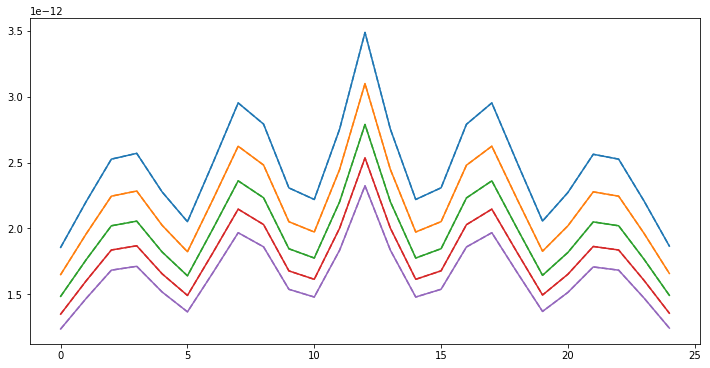

In [25]:
fg = plt.figure(figsize=(12,6))
ax1 = plt.gca()
print('*** local_inte: ', local_intensities_mgs.shape)
print('*** local_inte: ', local_intensities_mg.shape)
for k in [0, 20, 40, 60, 80]:
    #for j in range(0, 380, 20):
    #for j in range(0,len(local_intensities_mgs)):
        #ln, = ax1.plot(local_intensities_mg[k][j:j+20], ls='-')
    ln, = ax1.plot(local_intensities_mgs[k].T.ravel(), ls='-')
    #
    clr = ln.get_color()
    #        
    ax1.plot(local_intensities_mgr[k].ravel(), ls='--', color=clr)
    #
    #break
    

***  (100, 25) (100, 5, 5)


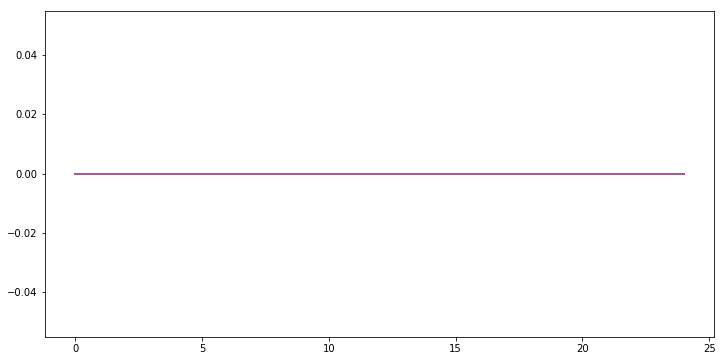

In [26]:
print('*** ', local_intensities_mgr.shape, local_intensities_mgs.shape)
#
fg = plt.figure(figsize=(12,6))
ax1 = plt.gca()
for k in [0, 20, 40, 60, 80]:
    ln, = ax1.plot((local_intensities_mgr[k] - local_intensities_mgs[k].T.ravel())/
                   (local_intensities_mgr[k] + local_intensities_mgs[k].T.ravel()) )
    #for j in range(local_intensities_mgr.shape[1]):
    #    ln, = ax1.plot((local_intensities_mgr[k][j]-local_intensities_mgs[k][j])/(local_intensities_mgr[k][j]+local_intensities_mgs[k][j]), ls='-')
    #    clr = ln.get_color()
    #ln, = ax1.plot( (local_intensities_mgr[k]-local_intensities_mgs[k])/
    #               (local_intensities_mgr[k]+local_intensities_mgs[k]),
    #               ls='-')
    #
        #ax1.plot(local_intensities_mg[k][j:j+20], ls='--', color=clr)
        #break
    #break
    pass
    

In [27]:
with h5py.File('my_h5.hdf5', 'w') as fout:
    ds1 = fout.create_dataset('ds1', (10, 100, 100), dtype='f')
    ds2 = fout.create_dataset('ds2', (20, 200, 200), dtype='d')
    dimensions = fout.create_group('dimensions')
    dim1 = dimensions.create_dataset('dim1', (10,),  dtype='f4')
    dim2 = dimensions.create_dataset('dim2', (100,), dtype='f8')
    dim3 = dimensions.create_dataset('dim3', (100,), dtype='f16')
    #
    # do we need to use dataset.write_direct() and dataset.read_direct() methods?
    # . is dataset[:]=vals or dataset[k:j]=vals[l:m] equivalent? Maybe not. read_/write_direct() 
    # . requires the numpy.array and/or hdf5 object to be c-contiguous (not chunked).
    #   my guess is that _direct() is faster, but les wieldy.
    #
    dim1[:] = numpy.linspace(0,5, len(dim1))
    dim2.write_direct(numpy.linspace(-115, 125, len(dim2)))
    dim3.write_direct(numpy.linspace(31., 36., len(dim3)))
    #
    ds2.write_direct(numpy.random.random(ds2.shape))
#

    #


with h5py.File('my_h5.hdf5', 'r') as fin:
    print('keys: ', fin.keys())
    #
    fin.visit(print)
    def f(ky):
        if hasattr(fin[ky], 'dtype'):
            print('** {}: {}'.format(ky, fin[ky].dtype) ) 
    #
    fin.visit(f)
    #
    print('dimn1: ', fin['dimensions']['dim1'][:])
#

keys:  <KeysViewHDF5 ['dimensions', 'ds1', 'ds2']>
dimensions
dimensions/dim1
dimensions/dim2
dimensions/dim3
ds1
ds2
** dimensions/dim1: float32
** dimensions/dim2: float64
** dimensions/dim3: float128
** ds1: float32
** ds2: float64
dimn1:  [0.        0.5555556 1.1111112 1.6666666 2.2222223 2.7777777 3.3333333
 3.8888888 4.4444447 5.       ]


In [28]:
from globalETAS import Earthquake
deg2km = 111.11
#
# TODO:
# maybe use numpy.digitize(x,bins) --> indices of bins into which x belong.??
# so set up the bins, then create indices with .digitize(), assign values
# with indices. I think this should be at least comparably as fast as requiring
# and assigning contiguous blocks. One trick will be to be to index on the dinmensionsm,
# so we don't have to evaluate the full 2/3D space (we can evaluate the 2/3 1D dimension
# . arrays).
#
# can we subset an HDF5... i guess file class?
def create_netas_hdf5(fname_out='my_hdf5.h5', times=None, times_to=None, lats=None, lons=None):
    # NOTE: lats, lons, and time arrays might be better called "dimensions".
    # . they are the unique values.
    # TODO: handle incomplete or improperly formatted times_to inputs.
    if os.path.isfile(fname_out):
        os.remove(fname_out)
    #
    if times_to is None:
        times_to = numpy.nan
    times_to = numpy.atleast_1d(times_to)
    #
    with h5py.File(fname_out, 'w') as fout:
        netas = fout.create_dataset("nETAS", (len(times), len(lats), len(lons)), dtype='d')
        #lats  = fout.create_dataset('lats', (len(lats),), dtype='>f8') 
        #
        # do we want to embrace the NetCDF 'dimension' convention?
        # dimensions = fout.create_group('dimensions')
        # lats = dimensions.create_dataset('lats', (len(lats),), data=lats) 
        lts     = fout.create_dataset('lats', (len(lats),), data=lats) 
        lns     = fout.create_dataset('lons', (len(lons),), data=lons)
        tmes    = fout.create_dataset('times', (len(times),), data=times)
        tmes_to = fout.create_dataset('times_to', (len(times_to),), data=times_to)
        #
    #
    return None  
#
class NETAS_collector():
    # the whole enchillada:
    # 1) we'll take a catalog as an input for now.
    # 2) Either from inputs or catalog, determine spatial and temporal extents.
    # 3) Define binning translator, j,k,l = f(lon), g(lat), h(t)
    # 4) create or reference an HDF5, NetCDF, or other container object to aggregate the data
    # 5) Loop through catalog:
    # .   1) Compute a NETAS_block().netas_block() for each event
    # .   2) Bin-Align returned data; aggregate into HDF5-like object
    def __init__(self, catalog=None, h5_file=None,
                 lons=None, lats=None,
                 lon_min=-180., lon_max=180., lat_min=-90., lat_max=90., d_lon=.1, d_lat=.1,
                 times=None, times_to=None
                 ):
        # ... and skip the lon/lat phase; those values are in the min values of the sequences.
        # . lon_bin_phase=0., lat_bin_phase=0.
        # TODO: sort out some default behaviors, like inferring time, lat, lon extents from catalog,
        # . fetching a catalog if lats, lons, times specified, etc...
        # . for now, think modular, and let it break if need be.
        #
        if not os.path.isfile(h5_file): 
            # NOTE: this is not a comprehensive way to build lon, lat domains in a periodic
            # . domain (on a sphere). We probably just need to be specific -- ie, pass the 
            # . lons, lats sequendcs directly.
            if lats is None:
                lats = numpy.arange(lat_min, lat_max+d_lat, d_lat)
            if lons is None:
                lons = numpy.arange(lon_min, lon_max+d_lon, d_lon)
            #
            #
            no_return = create_netas_hdf5(fname_out=h5_file, times=times, times_to=times_to,
                                          lats=lats,
                                          lons=lons)
            #
        #
        # if an h5 file was passed, we'd pull lons, lats from its dimension collection.
        with h5py.File(h5_file, 'r') as h5in:
            lats = h5in['lats'].copy()
            lons = h5in['lons'].copy()
            #
        # NOTE: Do they need to be in order? Is there value in permitting out of order?
        # for now, skip sorting. later, we'll build in some failsafes.
        #lats.sort()
        #lons.sort()
        #
        #lon_min, lon_max = min(lons), max(lons)
        #lat_min, lat_max = min(lats), max(lats)
        lon_min, lon_max = lons[0::len(lons)-1]
        lat_min, lat_max = lats[0::len(lats)-1]
        #
        #d_lon = numpy.mean(numpy.diff(lons))
        # TODO: consisder a diagnostic where we evaluate all or a bunch of these
        #. and look for consistency.
        d_lon = lons[1] - lons[0]
        d_lat = lats[1] - lats[0]
            #
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
        #
    #
    def compute_nETAS(self):
        for eq in self.catalog:
            block = NETAS_block(times=ts, **eq.input_parameters, spatial_intensity_threshold=.1)
            #block_netas = block.nETAS_block()
            #
            k_lons, x_lons = self.lon_to_bin(block.lons)
            k_lats, x_lats = self.lat_to_bin(block.lats)
            #
            # NOTE: this will break. we're working on this...
            with h5py.File(self.h5_file, 'a') as h5ap:
                h5ap[:k_lons:k_lats] += block.nETAS_block()
            
    #
    def lon_to_bin(self, lon, fp_factor=100):
        # return [[lon_bin_index, lon_bin_val], ...]
        #
        # int((self.lon - delta_lon + lon_phase)/d_lon)*d_lon
        #lon_binned = lon
        # from NETAS_block:
        # TODO: figure out how to more easily and consistently synch these up. we need
        # . uniform bin calculations across three interacting classes (hdf5 object, collector,
        # . NETAS_block). Probably, the thing to do is to use NETAS_block() as the primary
        #  (actually use its lat/lon binning function).
        # lat_min = int((self.lat - delta_lat + lat_phase)/d_lat)*d_lat
        # lon_min = int((self.lon - delta_lon + lon_phase)/d_lon)*d_lon
        #pass
        #
        #lon_bin_index = int((lon - self.lon_min)//self.d_lon)
        #
        #lon_bin_value = lon_bin_index*d_lon + self.lon_min
        #
        #return numpy.array([lon_bin_index, lon_bin_index*d_lon + self.lon_min ]).T
        return x_to_bin(lon, x_phase=0, d_x=self.d_lon, x_0=self.lon_min)
    #
    def lat_to_bin(self, lat, fp_factor=100):
        #lat_bin_index = int((lat - self.lat_min)//self.d_lat)
        ##lon_bin_value = lon_bin_index*d_lon + self.lon_min
        #
        #return numpy.array([lat_bin_index, lat_bin_index*d_lat + self.lat_min ]).T
        return x_to_bin(lat, x_phase=0, d_x=self.d_lat, x_0=self.lat_min)
    
#

In [29]:
fn = 'my_test.h5'
test_h5 = create_netas_hdf5(fname_out=fn, times=numpy.arange(0,5), times_to=None,
                            lats=numpy.arange(100.), lons=numpy.arange(50.))

with h5py.File(fn, 'r') as fin:
    print('** shape(nETAS): ', fin['nETAS'].shape)


** shape(nETAS):  (5, 100, 50)


In [30]:
def x_to_bin(x, x_phase=0., d_x=0.1, x_0=0., fp_factor=1.):
    '''
    # convert an input value x to a bin index. Return both the index and bin "value", 
    #. in this case, the left edge.
    # bin_index = int(x+x_phase)/dx - int(x0+x_phase)/dx)
    # bin_val   = float(int((x+x_phase)/d_x)*d_x)
    #
    # inputs:
    # @x: value to be binned
    # @x_phase: a phase shift, so maybe bin in .1 size bins, but on the .1+05
    # @d_x+ bin size
    # @x_0: starting point for x
    # @ fp_factor: a multiplier to mitigate floating point errors. Basically, you can use this
    #.  to boost the integer component of FP numbers, so you get more consistent arithmetic.
    '''
    #
    # TODO: we still need a smart way to synch the lat/lon bins in all of these classes.
    #
    # return index and value, [[lat_index, lat_val], ...]
    # . note re: index, we might be computing the 
    # lat_min = int((self.lat - delta_lat + lat_phase)/d_lat)*d_lat
    #
    #xs = float(int((x+x_phase)/d_x)*d_x)
    #
    # xs*d_x gives us the raw (global) indexing. we might want a smaller
    # . subset. Nominally there are couple of ways to do this -- subtract x_0
    # . before or after we do the binning. Compute speed is an issue, but
    # . this will be performed on the 1D dimensions, so it should be a minor
    # . issue. note the int() operator is transcendental, so might not comply
    # . with standard commutative and associative rules.
    #
    #ks = int((x+x_phase)/d_x) - int((x_0+x_phase)/d_x)
    d_x*=fp_factor
    #
    #print('*** ndim: ', numpy.ndim(x), x)
    if numpy.ndim(x)==0:
        return numpy.array([(int(fp_factor*(x+x_phase)/d_x) - int(fp_factor*(x_0+x_phase)/d_x)), 
                             float(int((x+x_phase)/d_x)*d_x) ]).T
        #return numpy.array([(int((x+x_phase)/d_x) - int((x_0+x_phase)/d_x)), 
        #                     float(int((x+x_phase)/d_x)*d_x) ]).T
    else:
        #
        return numpy.core.records.fromarrays([((fp_factor*(x+x_phase)/d_x).astype('>i8') -
                                               int(fp_factor*(x_0+x_phase)/d_x)).astype('>i8'), 
                             ((fp_factor*(x+x_phase)/d_x).astype('>i8')*d_x/fp_factor).astype('>f8') ],
                                             dtype=[('k', '>i8'), ('x', '>f8')])
        #return numpy.core.records.fromarrays([(((x+x_phase)/d_x).astype('>i8') - int((x_0+x_phase)/d_x)).astype('>i8'), 
        #                     (((x+x_phase)/d_x).astype('>i8')*d_x).astype('>f8') ],
        #                                     dtype=[('k', '>i8'), ('x', '>f8')])
    # .astype([('k','>i8'),
    #                                                                                          ('x', '>f8')])
#
X = numpy.random.random(size=(10))*5. + 37.1
print('** ', [[x, k, xx] for x, (k, xx) in zip(X, x_to_bin(X)) ])
print('**')
print('** ', [[x, k, xx] for x, (k, xx) in zip(X, x_to_bin(X, x_0=10.)) ])
#
X2 = -numpy.random.random(size=(10))*5. + -37.1
print('** ', [[x, k, xx] for x, (k, xx) in zip(X2, x_to_bin(X2)) ])
print('**')
print('** ', [[x, k, xx] for x, (k, xx) in zip(X2, x_to_bin(X2, x_0=-180.)) ])

**  [[39.30312822450237, 393, 39.300000000000004], [39.43085428509229, 394, 39.400000000000006], [37.92232052674754, 379, 37.9], [38.58983796742954, 385, 38.5], [40.5503230722523, 405, 40.5], [42.00337596410535, 420, 42.0], [40.094251771631, 400, 40.0], [37.50649889794644, 375, 37.5], [39.41449686256038, 394, 39.400000000000006], [40.510095549509344, 405, 40.5]]
**
**  [[39.30312822450237, 293, 39.300000000000004], [39.43085428509229, 294, 39.400000000000006], [37.92232052674754, 279, 37.9], [38.58983796742954, 285, 38.5], [40.5503230722523, 305, 40.5], [42.00337596410535, 320, 42.0], [40.094251771631, 300, 40.0], [37.50649889794644, 275, 37.5], [39.41449686256038, 294, 39.400000000000006], [40.510095549509344, 305, 40.5]]
**  [[-41.00732015885797, -410, -41.0], [-41.11705052580639, -411, -41.1], [-39.17452370214739, -391, -39.1], [-39.82913907814549, -398, -39.800000000000004], [-41.792278970824576, -417, -41.7], [-39.21284814023416, -392, -39.2], [-41.0232818639057, -410, -41.0], [-4

In [31]:
binners = x_to_bin(X)
#
print('** ', binners)
print('** ', binners.dtype)
#
#
binners2 = x_to_bin(X, fp_factor=100)
#
print('** ', binners2)
print('** ', binners2.dtype)

**  [(393, 39.3) (394, 39.4) (379, 37.9) (385, 38.5) (405, 40.5) (420, 42. )
 (400, 40. ) (375, 37.5) (394, 39.4) (405, 40.5)]
**  (numpy.record, [('k', '>i8'), ('x', '>f8')])
**  [(393, 39.3) (394, 39.4) (379, 37.9) (385, 38.5) (405, 40.5) (420, 42. )
 (400, 40. ) (375, 37.5) (394, 39.4) (405, 40.5)]
**  (numpy.record, [('k', '>i8'), ('x', '>f8')])


In [32]:
x1 = numpy.random.random(10)*5
x2 = numpy.random.random(10)*5
#
xx = numpy.core.records.fromarrays(numpy.random.random((2,10))*5, dtype=[('k', '>i8'), ('x', '>f8')])
#
print('** ', xx)

**  [(1, 2.7729914 ) (2, 1.82914716) (3, 4.51632123) (4, 1.40969058)
 (0, 3.41878643) (1, 4.24330215) (0, 0.52205905) (3, 0.98403403)
 (3, 3.03258125) (3, 4.77078149)]


** -200.0: 160.0, *(160.0, 42.0)
** -190.0: 170.0, *(170.0, 42.0)
** -180.0: -180.0, *(-180.0, 42.0)
** -150.0: -150.0, *(-150.0, 42.0)
** 0.0: 0.0, *(0.0, 42.0)
** 150.0: 150.0, *(150.0, 42.0)
** 180.0: -180.0, *(-180.0, 42.0)
** 190.0: -170.0, *(-170.0, 42.0)
** 200.0: -160.0, *(-160.0, 42.0)
**  [0 1 2 0 1 2 0 1 2 0]
**  (10.0, 80.0)
**  (-10.0, 80.0)
**  (170.0, 80.0)
**  (170.0, -80.0)
**  (-10.0, -80.0)
** **  [ 160.  170. -180. -150.    0.  150. -180. -170. -160.]


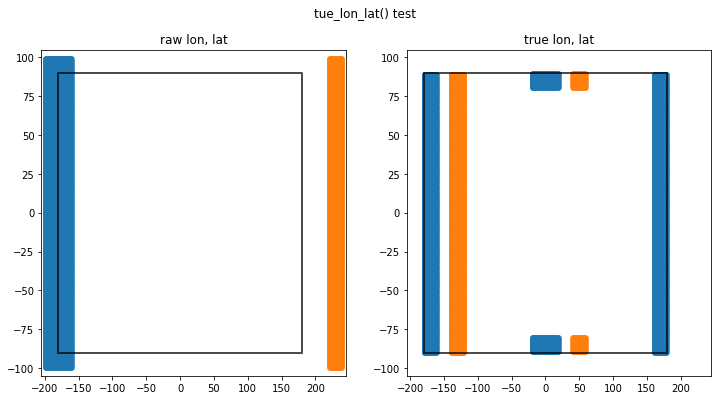

In [33]:
class NETAS_block(Earthquake):
    # Note: it might make more sense to include an Earthquke(), or list of Earthquake()s rather than subclassing.
    #. For batched MPP, for example, it would be possible to pre-construct a complete array of sites for multiple
    #  inputs (Earthquake()s). On the other hand, that introduces some opportunity for memory mis-management, 
    #. mistakes, or requiring indexing (aka, you have earthquakes that are not close together, maybe non-
    #. contiguous lattice sites)...
    def __init__(self, times=None, times_to=None, spatial_intensity_threshold=1e-2, time_intensity_threshold=None, 
                 lon_phase=0., lat_phase=0., d_lon=.1, d_lat=.1,
                 *args, **kwargs):
        '''
        # @times: an iterable of times
        # @spatial_intensity_threshold: compute range by invertng spatial-omori; solve for 1/this.
        # @time_intensity_threshold: same, but for temporal distributionz. again, x_min ~ x0/this
        #
        # removing lon_0, lat_0. We'll map the min addresses (lon, lat) to indices in a parent/calling
        # . function or class. we will substitute these with phase offsets, which we'll usually set to zero.
        # .  note, these should lon_phase < d_lon, lat_phase < d_lat.
        ## @lon_0, lat_0 : zero-point for lon, lat bins, respectively.
        # @lon_phase, @lat_phase: phase to add to lon, lat bins, respectively.
        ## # parent array binning:
        #
        # TODO: what is the best parent binning convention? allow negative bins indices? Maybe we just
        #. leave that up to the parent object. I think that, by itself, negative index labels, centered
        #. on LL=[0,0] is most intuitive.
        # @d_lon, d_lat : lon, lat bin sizes, respectively
        #. bin indices are then j = int((lon - lon_0)/d_lon), k = int( (lat - lat_0)/d_lat)
        # 
        # parent __init__(): __init__(self, dict_or_recarray, transform_type='equal_area', transform_ratio_max=5.,
            ab_ratio_expon=.5, t_1=None, t_2=None)
        #
        '''
        #
        # initialize the Earthquake() part:
        super(NETAS_block, self).__init__(*args, **kwargs)
        #
        # handle intensity threshold inputs:
        # NOTE: None does not make sense with this object. if we want to do an unrestricted, fully connected
        # . nETAS, use a different gridding object (just pass the full lattice dims to all events).
        #if not spatial_intensity_threshold is None:
        spatial_intensity_threshold = min(spatial_intensity_threshold, 1./spatial_intensity_threshold)
        if not time_intensity_threshold is None:
            time_intensity_threshold = min(time_intensity_threshold, 1./time_intensity_threshold)
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
        #
        # now, compute the spatial range and optionally the temporal range, or more specifically
        #   the lon, lat, time dimensions/indices. compute these as pairs: [[k_label, value], ...]
        #.  k_label: the index "label", or the index in a larger (global) lattice.
        #.  an we use their ordering for direct indexing.
        delta_lat = self.etas_range()/deg2km
        delta_lon = delta_lat*numpy.cos(self.lat*scipy.constants.degree)
        #
        # TODO: move this to a module level function?
        lat_min = int((self.lat - delta_lat + lat_phase)/d_lat)*d_lat
        lon_min = int((self.lon - delta_lon + lon_phase)/d_lon)*d_lon
        #
        #self.__dict__.update({'delta_lat':delta_lat, 'delta_lon':delta_lon, 'lat_min':lat_min, 'lon_min':lon_min})
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
        #
        # TODO: write these as functions to save memory? They will typically be called once
        #. and then return a 2D array of intensities.
        #lats = numpy.arange(lat_min, lat_min + 2*delta_lat, d_lat)
        #lats_index_labels = ((lats-lat_0)/d_lat).astype(int)
        #
        #lons = numpy.arange(lon_min, lon_min + 2*delta_lon, d_lon)
        #lons_index_labels = ((lons-lon_0)/d_lon).astype(int)
        #
    #
    @property
    def lats(self):
        # TODO: are we de-modularizing too much here? I think maybe we just compute lats and lons
        #. at this level. we leave the binning to the calling function. 
        #lats = numpy.arange(self.lat_min, self.lat_min + 2*self.delta_lat, self.d_lat)
        #lats_index_labels = ((self.lats-self.lat_0)/self.d_lat).astype(int)
        #
        #return numpy.core.records.fromarrays([lats_index_labels, lats], dtype=[('index', '>i8'), ('lat', '>f8')])
        return numpy.arange(self.lat_min, self.lat_min + 2*self.delta_lat, self.d_lat)
    #                           
    @property
    def lons(self):
        #lons = numpy.arange(self.lon_min, self.lon_min + 2*self.delta_lon, self.d_lon)
        #lons_index_labels = ((self.lons - self.lon_0)/self.d_lon).astype(int)
        #
        #return numpy.core.records.fromarrays([lons_index_labels, lons], dtype=[('index', '>i8'), ('lat', '>f8')])
        return numpy.arange(self.lon_min, self.lon_min + 2*self.delta_lon, self.d_lon)
    #
    def etas_range(self, spatial_intensity_threshold=None):
        spatial_intensity_threshold = spatial_intensity_threshold or self.spatial_intensity_threshold
        if spatial_intensity_threshold is None:
            return None
        #
        # TODO:
        # FIXME: 
        # what are the units for this formulation? i thought km, but...j
        # . this appears to actually be right, just a bit surprising how big r_0 is...
        # anyway, this may be wrong. or not useful, either untis or formula... or maybe just taht r_0 is 
        # . really big -- a lot bigger than rupture length (like 10x for an M7). We probably need to reevaluate
        #   our solutions for r_0. This could be an interesting ML exercise -- to ue the r_0 formulation that
        # . optimized predictability (or something).
        return self.r_0*(spatial_intensity_threshold**(-1./self.q) - 1.)
    #
    def etas_temporal_range(self, time_intensity_threshold=None):
        time_intensity_threshold = time_intensity_threshold or self.time_intensity_threshold
        if time_intensity_threshold is None:
            return None
        #
        return self.t_0*(time_intensity_threshold**(-1./self.p) - 1.)
    #
    def lons_lats_mgrid(self):
        return true_lon_lat(*numpy.meshgrid(self.lons, self.lats) )
    #
    def nETAS_block(self):
        #
        lons, lats = true_lon_lat(*numpy.meshgrid(self.lons, self.lats ) )
        #
        #print('*** DEBUG: shapes:: {}, {}'.format(lons.shape, lats.shape) )
        #print('*** DEBUG: shapes_true:: {}, {}'.format(true_lon(lons).shape, true_lat(lats).shape) )
        #
        return self.local_intensities(ts=self.times, ts_to=self.times_to, lons=lons, lats=lats )
    #
def true_lon(x):
    # lon can be corrected independently...
    return (x+180.)%360. - 180.
#
def true_lon_lat(X,Y):
    # lat introduces lon corrections...
    #
    # first latitude:
    Y_prime = (Y+90.)%360.
    m = Y_prime//180.
    #print('** DEBUG: ', m)
    #
    #print('*** ', m*180.)
    #print('*** ', (-1.)**m)
    #print('*** ', Y_prime%180.)
    #
    #Y_prime = m*180. + ((-1.)**m)*(Y_prime%180. )- 90.
    #
    #X_prime = ((X+180.) +m*180.)%360 - 180.
    #
    #return X_prime, Y_prime
    return ((X+180.) +m*180.)%360 - 180., m*180. + ((-1.)**m)*(Y_prime%180. )- 90.
#
#
# Some true_lon_lat() tests:
for x in (-200., -190., -180., -150., 0., 150., 180., 190., 200.):
    print('** {}: {}, *{}'.format(x, true_lon(x), true_lon_lat(x, 42.)))

print('** ', numpy.arange(10)%3)
print('** ', true_lon_lat(-170., 100))
print('** ', true_lon_lat(-190., 100))
print('** ', true_lon_lat(-190., 80))
print('** ', true_lon_lat(-190., -80))
print('** ', true_lon_lat(-190., -100))
    
# a graphical test of true_lon_lat:
X_test, Y_test = numpy.meshgrid(numpy.arange(-200., -160, .5), numpy.arange(-100., 100., .5))
X_prime, Y_prime = true_lon_lat(X_test, Y_test)
#
#
X_test2, Y_test2 = numpy.meshgrid(numpy.arange(220., 240, .5), numpy.arange(-100., 100., .5))
X_prime2, Y_prime2 = true_lon_lat(X_test2, Y_test2)
#
fg = plt.figure(figsize=(12, 6))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
#
plt.suptitle('tue_lon_lat() test')
ax1.set_title('raw lon, lat')
ax2.set_title('true lon, lat')
#
ax1.plot(X_test.ravel(), Y_test.ravel(), ls='', marker='.')
ax2.plot(X_prime.ravel(), Y_prime.ravel(), ls='', marker='.')
#
ax1.plot(X_test2.ravel(), Y_test2.ravel(), ls='', marker='.')
ax2.plot(X_prime2.ravel(), Y_prime2.ravel(), ls='', marker='.')
#
for ax in (ax1, ax2):    
    #
    ax.set_xlim(-205, 245)
    ax.set_ylim(-105, 105)
    #
    ax.plot([-180., 180., 180., -180., -180.], [-90., -90., 90., 90., -90.], 
            zorder=11, color='k', lw=2., alpha=.7)
    
print('** ** ', true_lon(numpy.array([-200., -190., -180., -150., 0., 150., 180., 190., 200.])))

In [34]:
ts = numpy.linspace(eq.event_date_float, eq.event_date_float+10., 10)

block = NETAS_block(times=ts, **eq.input_parameters, spatial_intensity_threshold=.1)
block_netas = block.nETAS_block()
#
print('block.shape: ', block_netas.shape, block.lats.shape, block.lons.shape )

print('** ', block.r_0, block.etas_range() )
print('** dist: {}, {}'.format(eq.spherical_dist(to_lon_lat=[eq.lon+1, eq.lat]),
                               eq.spherical_dist(to_lon_lat=[eq.lon, eq.lat+1])))
#
#
print('** at 30Lr: {}'.format((eq.local_intensities(ts=[eq.event_date_float], 
                            lons=[eq.lon], lats=[eq.lat+(30.*eq.L_r)/deg2km])/
                               eq.local_intensities(ts=[eq.event_date_float], 
                            lons=[eq.lon], lats=[eq.lat])
                              )[0][0] ) )
#
my_lons = numpy.ones(200)*eq.lon
my_lats = numpy.linspace(eq.lat, eq.lat+5., 200)
#li_line = eq.local_intensities(ts=numpy.array([mpd.date2num(dtm.datetime.now(pytz.timezone('UTC')))]),
li_line = eq.local_intensities(ts=[eq.event_date_float], lons=my_lons, lats=my_lats)

block.shape:  (10, 838, 680) (838,) (680,)
**  1277.0384715765306 4650.449038187024
** dist: 90.32094641321325, 111.3188450214511
** at 30Lr: 0.08747496163230828


/Users/myoder96/Codes/globalETAS/globalETAS.py:1539: RuntimeWarning: invalid value encountered in true_divide
  R_primes = Rs_sph * (numpy.linalg.norm(dxs_dys_prime, axis=1)/numpy.linalg.norm([dxs.ravel(),dys.ravel()], axis=0)).reshape(Rs_sph.shape)


In [35]:
print('lat_range: ', block.lats[0::len(block.lats)-1], block.lats[int(len(block.lats)/2)])
print('lon_range: ', block.lons[0::len(block.lons)-1], block.lons[int(len(block.lons)/2)])

lat_range:  [-6.  77.7] 35.89999999999985
lon_range:  [-151.5  -83.6] -117.50000000000193


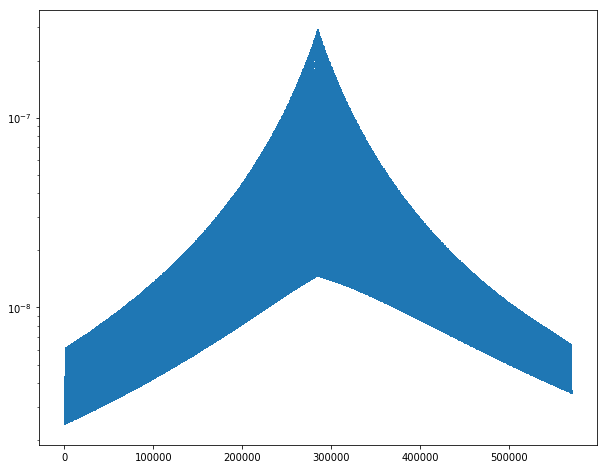

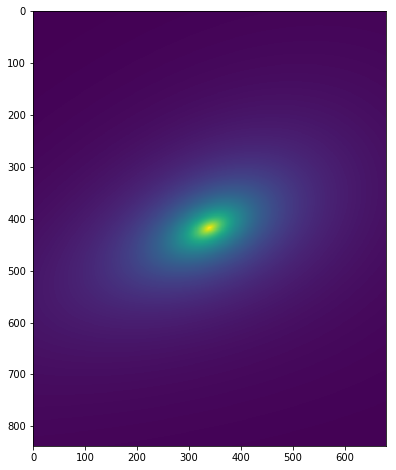

In [36]:
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.set_yscale('log')
ax.plot(block_netas[0].ravel(), ls='', marker=',')

fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.imshow(block_netas[0])


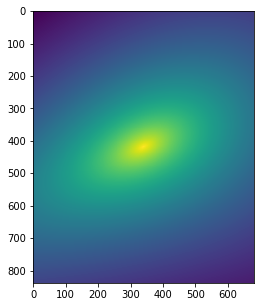

In [37]:
for k,rw in enumerate(block_netas):
    fg =plt.figure(figsize=(6,5))
    ax = plt.gca()
    #
    #ax.imshow(numpy.log(block_netas[6,:,:]))
    ax.imshow(numpy.log(block_netas[6,:,:]))
    break

In [38]:
#
print('** ', eq.L_r)
print('** ', (30.*eq.L_r)/deg2km)
print('** ', 61.65*30/111.1)
#
print('** ** ', eq.local_intensities(ts=[eq.event_date_float], 
                            lons=[eq.lon], lats=[eq.lat+(30.*eq.L_r)/deg2km] ) /li_line[0][0] )
#
my_lns = numpy.linspace(0,5,10)
my_lts = numpy.linspace(0,5,20)
#
lngs, ltgs = numpy.meshgrid(my_lns, my_lts)
#
print('** ', lngs.shape, ltgs.shape )

**  61.65950018614819
**  16.648231532575338
**  16.647164716471647
** **  [[0.08747496]]
**  (20, 10) (20, 10)


***  (1, 200)


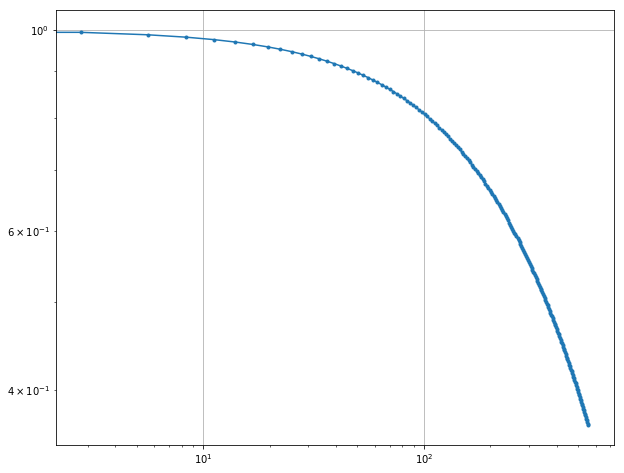

In [39]:
print('*** ', li_line.shape)
#print('** ', ((eq.chi*eq.r_0**eq.q)*(eq.tau*eq.t_0**eq.p)) )

fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
ax1.set_yscale('log')
ax1.set_xscale('log')
#
t0_norm = li_line[0][0]
#t0_norm = 1.0
ax1.plot(eq.spherical_dist(to_lon_lat=numpy.array([my_lons, my_lats])), 
         li_line[0,:]/t0_norm,
                     ls='-', marker='.')

In [40]:
XX, YY = block.lons_lats_mgrid()

In [41]:
print('*** ', XX.shape, YY.shape)
print('*** ', block.delta_lat, block.delta_lon)
print('*** ', block.etas_range() )
print('*** ', eq.mag)
#print('*** ', 100./deg2km)

***  (838, 680) (838, 680)
***  41.85445988828209 33.959666238280114
***  4650.449038187024
***  7.1


In [42]:
rates = block.nETAS_block()

In [43]:
print('*** ', eq.spherical_dist(to_lon_lat =([eq.lon+1., eq.lat+1.])) )

***  142.99075064998948


In [44]:
print('** ', scipy.constants.degree*360.)

A = numpy.random.random(20)*20
print(A)
print(A.astype(int) )

**  6.283185307179586
[13.09585633  2.66294905 19.66743198 15.57272209  0.43333089 13.02428616
  1.07087645  1.57480674  6.42678222 18.59371436  7.73950817 11.41359269
  5.86711043  1.05697555  4.03711965  0.558913    1.67950935 18.37890199
 19.86622648  8.78717478]
[13  2 19 15  0 13  1  1  6 18  7 11  5  1  4  0  1 18 19  8]


In [45]:
print(numpy.arange(5,10,.1))

[5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7
 6.8 6.9 7.  7.1 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5
 8.6 8.7 8.8 8.9 9.  9.1 9.2 9.3 9.4 9.5 9.6 9.7 9.8 9.9]


In [46]:
def f_lon(x):
    return (x+180)%360. - 180

for x in [-190., -120., -115., 120., 115., 190.]:
    print('** {} : {}'.format(x, f_lon(x)))
#


** -190.0 : 170.0
** -120.0 : -120.0
** -115.0 : -115.0
** 120.0 : 120.0
** 115.0 : 115.0
** 190.0 : -170.0


In [47]:
#########
# we're getting a small difference in local_intensities() values for lon,lat submitted as a 1D (with labels)
#. array, aka [lon0, lon0, lon0,...],  [lat0, lat1, lat2, ...] vs 2D arrays (lon and lat are each 2D arrays,
#. indexed by array position).
#
# the difference is on order 10**-17 for values of 10**-12 (so, one part in 10**5). this could be a float/double
#. type thing, or it could be something else...
# they seem to equal; it is possible the type difference becomes expressed somnewhere else, or maybe it's a lat/lon
# conversion issue, which would explain the symmetrical shape of the error.
#
lon_dim = numpy.linspace(eq.lon-2., eq.lon+2., 5)
lat_dim  = numpy.linspace(eq.lat-2., eq.lat+2., 5)
#
lons_mg, lats_mg = numpy.meshgrid(lon_dim, lat_dim)
#LL_i = numpy.array(list(itertools.product(lon_dim, lat_dim)))
LL_i = numpy.array([[b,a] for a,b in itertools.product(lat_dim, lon_dim)])
LL_r = numpy.array([lons_mg.ravel(), lats_mg.ravel()]).T
#


print('lon: ', lon_dim)
print('lat: ', lat_dim)
#
print('lons_mg: ', lons_mg)
print('lats_mg: ', lats_mg)
#
#
print('LL_i: ', LL_i)
print('LL_r: ', LL_r)
#
print('** ?? LL_i == LL_r? {}'.format(LL_i == LL_r))
#
# this all appears to check out so far. what about spherical distances?

#Rs_sph_i = eq.spherical_dist(to_lon_lat = numpy.array([lons, lats]))
Rs_sph_i = eq.spherical_dist(to_lon_lat = LL_i.T )
Rs_sph_r = eq.spherical_dist(to_lon_lat = LL_r.T )
Rs_sph_r2 = eq.spherical_dist(to_lon_lat = numpy.meshgrid(lon_dim, lat_dim))



lon:  [-119.5993333 -118.5993333 -117.5993333 -116.5993333 -115.5993333]
lat:  [33.7695 34.7695 35.7695 36.7695 37.7695]
lons_mg:  [[-119.5993333 -118.5993333 -117.5993333 -116.5993333 -115.5993333]
 [-119.5993333 -118.5993333 -117.5993333 -116.5993333 -115.5993333]
 [-119.5993333 -118.5993333 -117.5993333 -116.5993333 -115.5993333]
 [-119.5993333 -118.5993333 -117.5993333 -116.5993333 -115.5993333]
 [-119.5993333 -118.5993333 -117.5993333 -116.5993333 -115.5993333]]
lats_mg:  [[33.7695 33.7695 33.7695 33.7695 33.7695]
 [34.7695 34.7695 34.7695 34.7695 34.7695]
 [35.7695 35.7695 35.7695 35.7695 35.7695]
 [36.7695 36.7695 36.7695 36.7695 36.7695]
 [37.7695 37.7695 37.7695 37.7695 37.7695]]
LL_i:  [[-119.5993333   33.7695   ]
 [-118.5993333   33.7695   ]
 [-117.5993333   33.7695   ]
 [-116.5993333   33.7695   ]
 [-115.5993333   33.7695   ]
 [-119.5993333   34.7695   ]
 [-118.5993333   34.7695   ]
 [-117.5993333   34.7695   ]
 [-116.5993333   34.7695   ]
 [-115.5993333   34.7695   ]
 [-11

In [48]:
print('** ii', Rs_sph_i)
print('** r1', Rs_sph_r)
print('** r2', Rs_sph_r2.T)
print('**\n**:: ', (Rs_sph_i == Rs_sph_r).all() )
print('** :: ', (Rs_sph_r.ravel() == (Rs_sph_r2.T).ravel()).all() )

** ii [288.10684737 240.68080891 222.63769004 240.68080891 288.10684737
 213.14203774 143.70631776 111.31884502 143.70631776 213.14203774
 180.63954247  90.32094641   0.          90.32094641 180.63954247
 211.20820178 142.99075065 111.31884502 142.99075065 211.20820178
 285.24429538 239.82691633 222.63769004 239.82691633 285.24429538]
** r1 [288.10684737 240.68080891 222.63769004 240.68080891 288.10684737
 213.14203774 143.70631776 111.31884502 143.70631776 213.14203774
 180.63954247  90.32094641   0.          90.32094641 180.63954247
 211.20820178 142.99075065 111.31884502 142.99075065 211.20820178
 285.24429538 239.82691633 222.63769004 239.82691633 285.24429538]
** r2 [[288.10684737 213.14203774 180.63954247 211.20820178 285.24429538]
 [240.68080891 143.70631776  90.32094641 142.99075065 239.82691633]
 [222.63769004 111.31884502   0.         111.31884502 222.63769004]
 [240.68080891 143.70631776  90.32094641 142.99075065 239.82691633]
 [288.10684737 213.14203774 180.63954247 211.208

In [49]:
# Still chasing down what looks like a (relatively) benign numerical error, 
# . somehow related to re-shaping an array to/from 1D from/to 2D.
#
# related, but separately too, let's confirm how numpy.outer() aligns. We know that .outer(a,b)
# . ravels the output, so .outer([p,], [n,m]) -> [p, n*m] (or something like that). let's be
# . sure it's re-shaping the way we think it is...
#
# how does .outer() align?
#
xx = numpy.arange(24).reshape((6,4))
tt = numpy.arange(1.,10.)
print('** xx: ', xx)
print('** tt: ', tt)
#
xx_tt = numpy.outer(xx,tt)
#
print('*** shape(xx_tt): ', numpy.shape(xx_tt))
print('*** ', xx_tt)
#
# so this shape is row, column, time. utterly non-intuitive to me, but we can still
# . use the inherited indexing to slice it. aka, if we want the time-series for a given grid elementm,
# . X[j,k,:]
print('*** reshape shape: ', numpy.reshape(xx_tt, (*xx.shape, *tt.shape)).shape)
print('*** reshape:', numpy.reshape(xx_tt, (*xx.shape, *tt.shape)))

** xx:  [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]]
** tt:  [1. 2. 3. 4. 5. 6. 7. 8. 9.]
*** shape(xx_tt):  (24, 9)
***  [[  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   2.   3.   4.   5.   6.   7.   8.   9.]
 [  2.   4.   6.   8.  10.  12.  14.  16.  18.]
 [  3.   6.   9.  12.  15.  18.  21.  24.  27.]
 [  4.   8.  12.  16.  20.  24.  28.  32.  36.]
 [  5.  10.  15.  20.  25.  30.  35.  40.  45.]
 [  6.  12.  18.  24.  30.  36.  42.  48.  54.]
 [  7.  14.  21.  28.  35.  42.  49.  56.  63.]
 [  8.  16.  24.  32.  40.  48.  56.  64.  72.]
 [  9.  18.  27.  36.  45.  54.  63.  72.  81.]
 [ 10.  20.  30.  40.  50.  60.  70.  80.  90.]
 [ 11.  22.  33.  44.  55.  66.  77.  88.  99.]
 [ 12.  24.  36.  48.  60.  72.  84.  96. 108.]
 [ 13.  26.  39.  52.  65.  78.  91. 104. 117.]
 [ 14.  28.  42.  56.  70.  84.  98. 112. 126.]
 [ 15.  30.  45.  60.  75.  90. 105. 120. 135.]
 [ 16.  32.  48.  64.  80.  96. 112. 128. 144.]
 [ 17.  34.  51.

In [50]:
tt_xx = numpy.outer(tt,xx)
#
# this is, i assumne, not more correct than the previous orientation, but IMHO
# . much more intuitive. again, if we want the time series of agiven grid element,
# . X[:,j,k]
print('** shape(tt_xx): ', numpy.shape(tt_xx))
print('** ', tt_xx)
print('*** ', tt_xx.reshape(*tt.shape, *xx.shape) )

** shape(tt_xx):  (9, 24)
**  [[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
   14.  15.  16.  17.  18.  19.  20.  21.  22.  23.]
 [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
   28.  30.  32.  34.  36.  38.  40.  42.  44.  46.]
 [  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
   42.  45.  48.  51.  54.  57.  60.  63.  66.  69.]
 [  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
   56.  60.  64.  68.  72.  76.  80.  84.  88.  92.]
 [  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
   70.  75.  80.  85.  90.  95. 100. 105. 110. 115.]
 [  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
   84.  90.  96. 102. 108. 114. 120. 126. 132. 138.]
 [  0.   7.  14.  21.  28.  35.  42.  49.  56.  63.  70.  77.  84.  91.
   98. 105. 112. 119. 126. 133. 140. 147. 154. 161.]
 [  0.   8.  16.  24.  32.  40.  48.  56.  64.  72.  80.  88.  96. 104.
  112. 120. 128. 136. 1

In [51]:
# accessing the sequence with swapped axes:
#
xx_tt_s = numpy.reshape(xx_tt, (*xx.shape, *tt.shape))
tt_xx_s = numpy.reshape(tt_xx, (*tt.shape, *xx.shape))

print('** ', xx_tt_s[1,2,:])
print('** ', tt_xx_s[:,1,2])

**  [ 6. 12. 18. 24. 30. 36. 42. 48. 54.]
**  [ 6. 12. 18. 24. 30. 36. 42. 48. 54.]


In [52]:
print(xx_tt.shape)
print(tt_xx.shape)

(24, 9)
(9, 24)


li_shape[0]: (10, 50, 50)
li_shape[1]: (10, 2500)
li_shape[2]: (10, 2500)
(itr==mgr).all() False
******


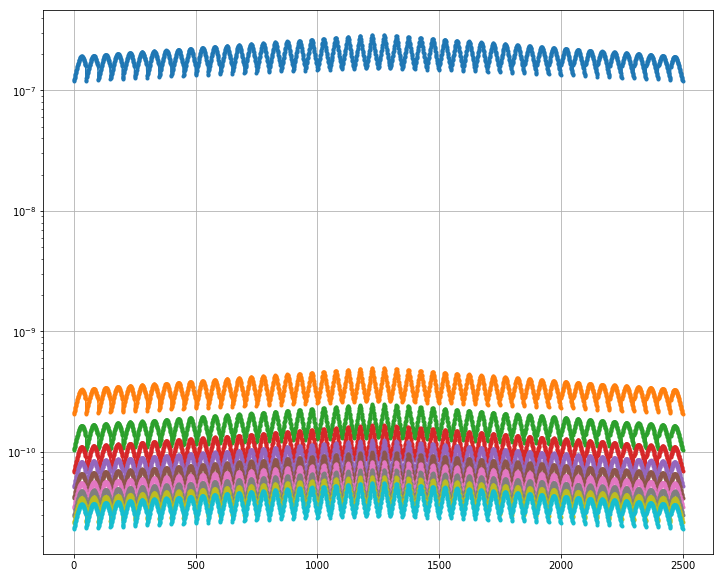

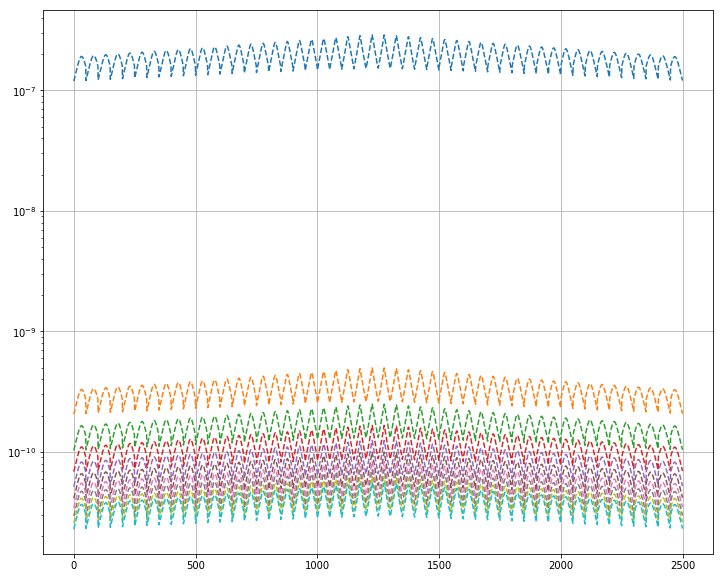

In [53]:
# create three versions of lons, lats:
# 1) itertools
# 2) meshgrid
# 3) meshgrid, then raveled to look like itertools
#
lon_dim = numpy.linspace(eq.lon-3., eq.lon+3., 50)
lat_dim  = numpy.linspace(eq.lat-3., eq.lat+3., 50)
#
# note: we might want to transpose these. meshgrid() and itertools.product() basically 
#. create transposed versinos of the same data product.
#
lons_mg, lats_mg = numpy.meshgrid(lon_dim, lat_dim)
LL_i = numpy.array([[b,a] for a,b in itertools.product(lat_dim, lon_dim)])
LL_r = numpy.array([lons_mg.ravel(), lats_mg.ravel()]).T

#
# NOTE: I think this is the right way to compare 2D and ravel()ed data.
# TODO: figure these out...
local_intensities_mgs = block.local_intensities(ts=ts, lons=lons_mg, lats=lats_mg)
local_intensities_mgr = eq.local_intensities(ts=ts, lons=lons_mg.T.ravel(), lats=lats_mg.T.ravel())
# this might all be wrong (axes not alligned correctly) now...
local_intensities_itr = eq.local_intensities(ts=ts, lons=LL_i[:,0], lats=LL_i[:,1])

for k, li in enumerate([local_intensities_mgs, local_intensities_mgr, local_intensities_itr]):
    print('li_shape[{}]: {}'.format(k, li.shape))
#print('li_shapes: ', local_intensities.shape)
#print('** ', local_intensities[0][0:20])
#
#print('mgs==mgr: ', local_intensities_mgs.reshape(local_intensities_mgr.shape)==local_intensities_mgr)
#print('mgs==itr: ',  (local_intensities_mgs==local_intensities_itr.reshape(-1, 5,5)))
#
# these basically are equal, with a nan issue in the middle.
#print('itr==mgr: ', (local_intensities_itr==local_intensities_mgr))
print('(itr==mgr).all()', (local_intensities_itr==local_intensities_mgr).all())
print('******')
#
# local_intensities_mgs.reshape(local_intensities_mgr.shape)==local_intensities_mgr
#
fg = plt.figure(figsize=(12,10))
ax = plt.gca()
ax.grid()
ax.set_yscale('log')
#
for k, (rw1, rw2) in enumerate(zip(local_intensities_mgs, local_intensities_mgr) ):
    #if k%10!=0:
    #    continue
    #if k==0: continue
    #
    ln, = ax.plot(rw1.T.ravel(), ls='-')
    clr = ln.get_color()
    ax.plot(rw2.ravel(), ls='--', color=clr, marker='.')
    #

# #
fg = plt.figure(figsize=(12,10))
ax = plt.gca()
ax.grid()
ax.set_yscale('log')
#
for k, (rw1, rw2) in enumerate(zip(local_intensities_mgs, local_intensities_mgr) ):
    #if k%10!=0:
    #    continue
    #
    ln, = ax.plot(rw1.reshape(rw2.shape)[0], ls='-')
    clr = ln.get_color()
    ax.plot(rw2.ravel(), ls='--', color=clr)
    #

# #

In [54]:
print('** ', local_intensities_mgs.shape)

**  (10, 50, 50)


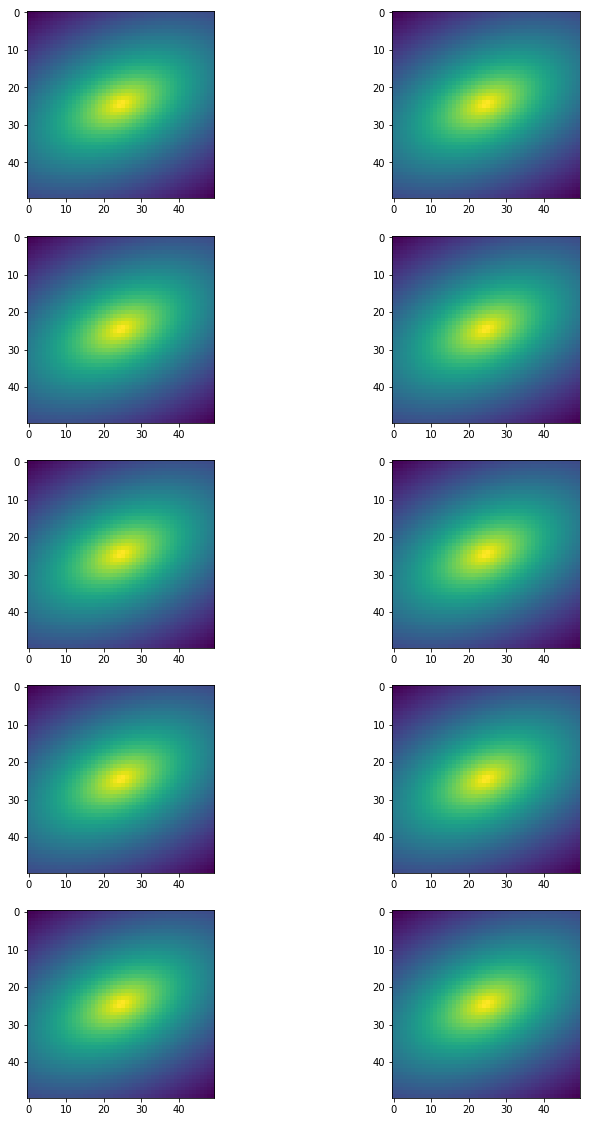

In [55]:
fg = plt.figure(figsize=(12,20))
ax = plt.gca()
#
for k,rw in enumerate(local_intensities_mgs):
    ax = plt.subplot(5,2, k+1)
    
    ax.imshow(numpy.array(rw))

In [56]:
block2 = NETAS_block(times=ts, **eq.input_parameters, spatial_intensity_threshold=.5, d_lat=.25, d_lon=.25)
print('** ', len(block2.lats))
print('** ', block2.lats)
print('** ', block2.lat, block2.lon)

**  55
**  [29.   29.25 29.5  29.75 30.   30.25 30.5  30.75 31.   31.25 31.5  31.75
 32.   32.25 32.5  32.75 33.   33.25 33.5  33.75 34.   34.25 34.5  34.75
 35.   35.25 35.5  35.75 36.   36.25 36.5  36.75 37.   37.25 37.5  37.75
 38.   38.25 38.5  38.75 39.   39.25 39.5  39.75 40.   40.25 40.5  40.75
 41.   41.25 41.5  41.75 42.   42.25 42.5 ]
**  35.7695 -117.5993333


In [57]:
# lons, lats = numpy.meshgrid(true_lon(self.lons), true_lat(self.lats) )
#         #
#         #print('*** DEBUG: shapes:: {}, {}'.format(lons.shape, lats.shape) )
#         #print('*** DEBUG: shapes_true:: {}, {}'.format(true_lon(lons).shape, true_lat(lats).shape) )
#         #
#         return self.local_intensities(ts=self.times, ts_to=self.times_to, lons=lons, lats=lats )

my_lns, my_lts = true_lon_lat(*numpy.meshgrid(lons, lats))
zs = block2.local_intensities(ts=block2.times, lons=my_lns, lats=my_lts)
#
print('** shape(zs): {}'.format(zs.shape))

#zs = block.nETAS_block()

** shape(zs): (10, 2, 2)


In [58]:
print('** ', zs.shape)
print('** ', block2.lats.shape, block2.lons.shape)
X,Y = numpy.meshgrid(block2.lons, block2.lats)
zs = block2.local_intensities(ts=block2.times, lons=X, lats=Y)

**  (10, 2, 2)
**  (55,) (44,)


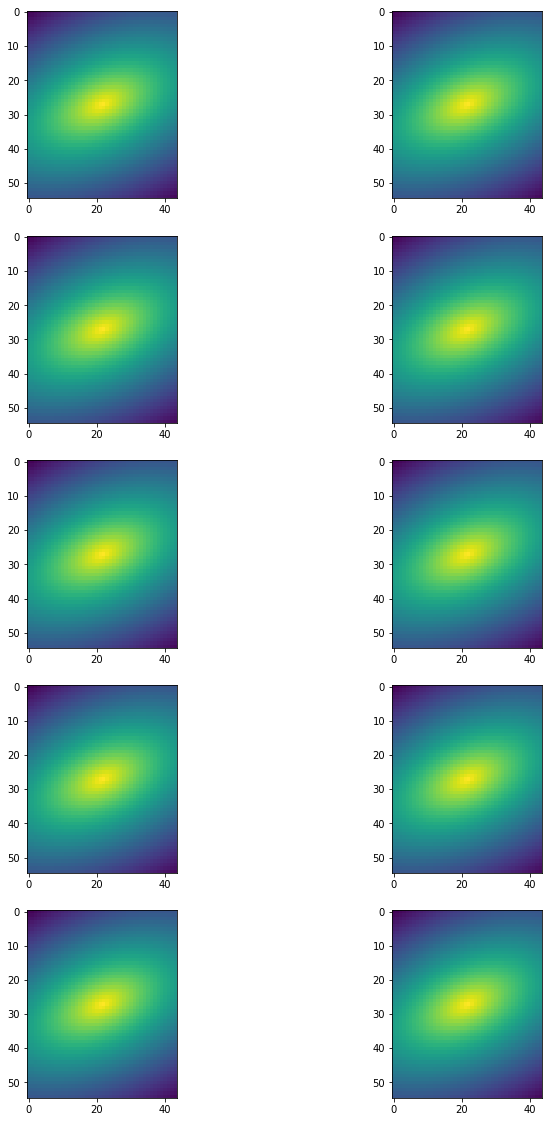

In [59]:
fg = plt.figure(figsize=(12,20))
ax = plt.gca()
#
for k,rw in enumerate(zs):
    ax = plt.subplot(5,2, k+1)
    
    ax.imshow(numpy.log(rw))

In [60]:
#
# an HDF5 experiment:
#with h5py.File('my_halos.')
fname = 'my_halos.h5'
create_netas_hdf5(fname_out=fname, times=numpy.arange(len(local_intensities_mgs)),
                  times_to=None, lats=lat_dim, lons=lon_dim)

*** keys:  <KeysViewHDF5 ['lats', 'lons', 'nETAS', 'times', 'times_to']>
*** shape[0]: (50, 50) :: (10, 50, 50)


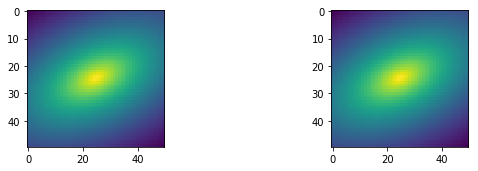

In [61]:
fg = plt.figure(figsize=(10,60))
k0=20
n_rw = local_intensities_mgs.shape[0] + 1
#
with h5py.File(fname, 'a') as fout:
    #
    fout['nETAS'][:]=local_intensities_mgs
    print('*** keys: ', fout.keys() )
#
with h5py.File(fname, 'a') as fout:
    for k,rw in enumerate(local_intensities_mgs):
        #print('** ', rw)
        #
        #fin['nETAS'][k::]=rw[::]
        #
        if k%20==0:
            #
            print('*** shape[{}]: {} :: {}'.format(k, rw.shape, fout['nETAS'].shape) )
            #
            j = int(k//k0)+1
            ax1 = plt.subplot(k0,2,j)
            ax2 = plt.subplot(k0,2,j+1)
            #
            ax1.imshow(local_intensities_mgs[k])
            ax2.imshow(fout['nETAS'][k])
        #
    #
#
#with h5py.File(fname, 'a') as fout:
#    fout['nETAS'][:]=local_intensities_mgs
#

In [62]:
# Now, let's do a semi-operational test:
# for now, start with our existing eq.
# We'll move it a few times (just adjust eq.input_parameters['lat', 'lon'])
# then, stack a couple on top of one another to test addition. For now, just use a global lattice -- for good
#. measure!
#
# make an hdf5 object
my_times = eq.event_date_float + numpy.arange(0., 10., 1.)
#
fname = 'global_toy.h5'
fname2 = 'global_toy2.h5'
#
h5_global = nETAS.create_netas_hdf5(fname_out=fname, times=my_times, times_to=None,
                              lats=numpy.arange(-90., 90., .1), lons=numpy.arange(-180., 180., .1))

h5_global_1d = nETAS.create_netas_hdf5_1D(fname_out=fname2, times=my_times, times_to=None,
                              lats=numpy.arange(-90., 90., .1), lons=numpy.arange(-180., 180., .1))

ary_output = numpy.zeros((len(my_times), 1800, 3600))
#
with h5py.File(fname, 'r') as fin:
    print('*** nETAS.shape', fin['nETAS'].shape)
with h5py.File(fname2, 'r') as fin:
    print('*** nETAS_1d.shape', fin['nETAS'].shape)
#

# lay down some earthquakes...
NC = nETAS.NETAS_collector(h5_file=fname)
k_t = numpy.arange(len(my_times))
#
print('** eq lon: {}, lat: {}'.format(eq.lon, eq.lat))
#
#for n, (dx, dy) in enumerate(itertools.product(numpy.arange(-2., 2.), numpy.arange(-2., 2.)) ):
for n, (dx, dy) in enumerate(itertools.product([-20., -10., 0., 10., 20.], [-20., -10., 0., 10., 20.]) ):
    t0 = time.time()
    #
    prms = eq.input_parameters.copy()
    #prms['dict_or_recarray']['lon'] += dx
    #prms['dict_or_recarray']['lat'] += dy
    prms['dict_or_recarray']['lon'] = eq.lon + dx
    prms['dict_or_recarray']['lat'] = eq.lat + dy
    #
    blk = nETAS.NETAS_block(times=my_times, **prms, spatial_intensity_threshold=.5, d_lat=.1, d_lon=.1)
    #zs = blk.local_intensities
    zs = blk.nETAS_block()
    #
#     fg = plt.figure()
#     ax = plt.gca()
#     ax.imshow(zs[0])
    #
    k_x = NC.lon_to_bin(blk.lons)
    k_y = NC.lat_to_bin(blk.lats)
    #
    #print('** DEBUG: k_x:: ', k_x)
    #print('** DEBUG: k_y:: ', k_y)
    #
    print('*** *** {}'.format(ary_output.shape))
    with h5py.File(fname, 'a') as fout:
        print('*** shapes[{}]: zs:{}, h5/ary:{}/{}, x:{}, y:{}'.format(n, zs.shape, fout['nETAS'].shape, 
                                                ary_output.shape, k_x['k'].shape, k_y['k'].shape) )
    #
    # this sort of indexing appears to just not work. we'll probably want to raster() it out.
    #print('*** subarray.shape: ', ary_output[:,k_y['k'],k_x['k']].shape)
    #print('*** subarray.shape: ', ary_output[:,k_x['k'],k_y['k']].shape)
    #
    t1 = time.time()
    #ary_output[:,k_x['k'],k_y['k']] = zs
    # now, meshgrid(times, lats, lons) (or some order); be careful of alignment,
    # and ravel those out to do nd_to_ravel_index():
    #
    # TODO: check this, but note that it is probably not critical for the alignment of the 
    #. array to be known, since we are using a positional index.
    #
    # meshgrid is not aligning correctly, or something (we don't resolve one spatial dimension).
    #. maybe just not working right with 3D?
    #kt_m, ky_m, kx_m = numpy.meshgrid(k_t, k_y['k'], k_x['k'])
    kt_m, ky_m, kx_m = numpy.array(list(itertools.product(k_t, k_y['k'], k_x['k']))).T
    #
    # this is significantly faster than looping over the array:
    ary_output.ravel()[nd_to_ravel_index(numpy.array([kt_m.ravel(), ky_m.ravel(), kx_m.ravel()]).T,
                                         ary_output.shape )] += zs.ravel()
    #
    #for k,j in itertools.product(k_y['k'], k_x['k']):
    #         ary_output[:,k,j]+=zs[:,k-k_y['k'][0], j-k_x['k'][0]]
    
    print('ary written: {}\n'.format(time.time()-t1))
    #
# now, dump to hdf5:
t1 = time.time()
with h5py.File(fname, 'a') as fout:
    fout['nETAS'][:] += ary_output[:]
#
print('h5 updated: {}\n'.format(time.time()-t1))
    #
#     t1 = time.time()
#     with h5py.File(fname, 'a') as fout:
#         print('*** shapes[{}]: {}, {}, {},{}'.format(n, zs.shape, fout['nETAS'].shape,
#                                                      k_x['k'].shape, k_y['k'].shape) )
#         #
#         kt_m, ky_m, kx_m = numpy.meshgrid(k_t, k_y['k'], k_x['k'])
#         #
#         #t0 = time.time()
#         #print('** time: {}'.format(time.time()-t0))
#         #
#         fout['nETAS'].ravel()[nd_to_ravel_index(numpy.array([kt_m.ravel(), ky_m.ravel(), kx_m.ravel()]).T,
#                                          ary_output.shape)] += zs.ravel()
#         #
#         #k_r = fout['nETAS'].shape[0]
#         #
#         # this isn't fast, but it should work. 
#         #for k,j in itertools.product(k_y['k'], k_x['k']):
#         #    fout['nETAS'][:,k,j]+=zs[:,k-k_y['k'][0], j-k_x['k'][0]]
#         #
#         print('h5 written: {}'.format(time.time()-t1))
#     #
    
    

*** nETAS.shape (10, 1800, 3600)
*** nETAS_1d.shape (64800000,)
** eq lon: -117.5993333, lat: 35.7695
*** *** (10, 1800, 3600)
*** shapes[0]: zs:(10, 136, 130), h5/ary:(10, 1800, 3600)/(10, 1800, 3600), x:(130,), y:(136,)
ary written: 0.11644697189331055

*** *** (10, 1800, 3600)
*** shapes[1]: zs:(10, 136, 122), h5/ary:(10, 1800, 3600)/(10, 1800, 3600), x:(122,), y:(136,)
ary written: 0.10953688621520996

*** *** (10, 1800, 3600)
*** shapes[2]: zs:(10, 136, 110), h5/ary:(10, 1800, 3600)/(10, 1800, 3600), x:(110,), y:(136,)
ary written: 0.10183405876159668

*** *** (10, 1800, 3600)
*** shapes[3]: zs:(10, 136, 95), h5/ary:(10, 1800, 3600)/(10, 1800, 3600), x:(95,), y:(136,)
ary written: 0.07873415946960449

*** *** (10, 1800, 3600)
*** shapes[4]: zs:(10, 136, 76), h5/ary:(10, 1800, 3600)/(10, 1800, 3600), x:(76,), y:(136,)
ary written: 0.061884164810180664

*** *** (10, 1800, 3600)
*** shapes[5]: zs:(10, 136, 130), h5/ary:(10, 1800, 3600)/(10, 1800, 3600), x:(130,), y:(136,)
ary written

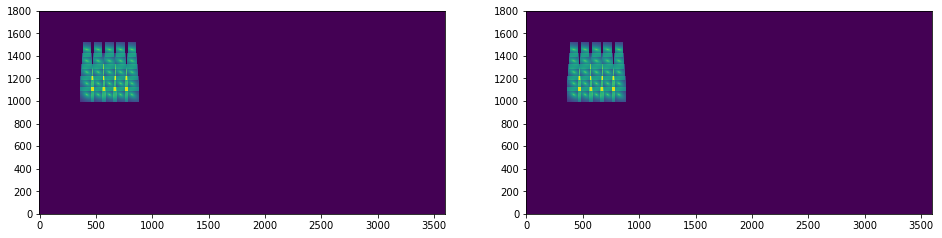

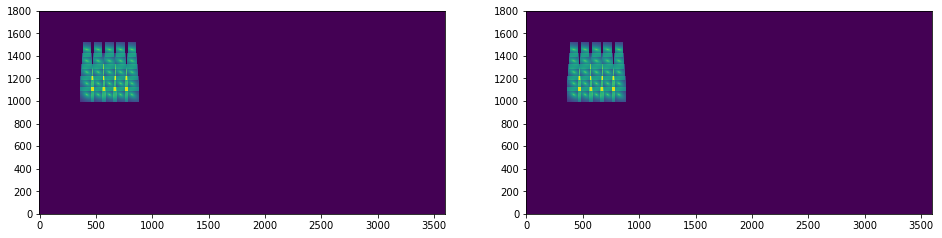

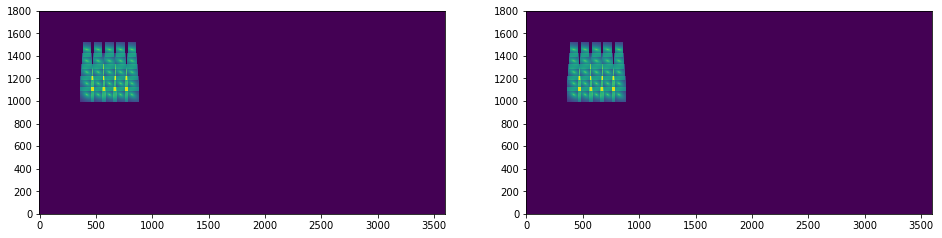

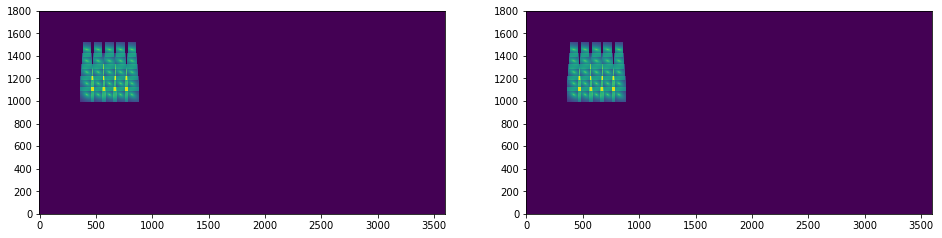

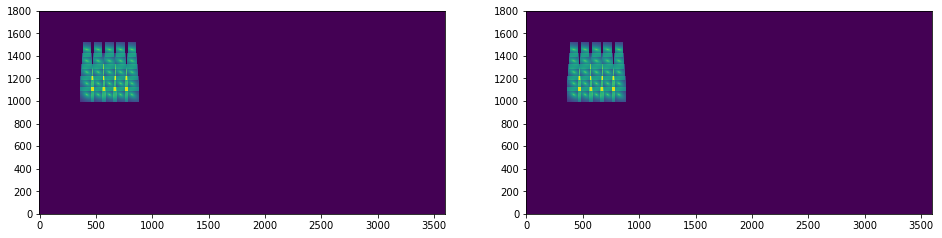

In [63]:
with h5py.File(fname, 'r') as fin:
    for lyr, lyr_h in zip(ary_output[0:5], fin['nETAS'][0:5]):
        fg = plt.figure(figsize=(16,6))
        ax1 = plt.subplot('121')
        ax2 = plt.subplot('122')
        #ax1.imshow(numpy.array(lyr[1000:1500,200:1100]), origin='lower')
        ax1.imshow(numpy.array(lyr[::]), origin='lower')
        #
        #ax2.imshow(numpy.array(lyr_h[1000:1500,200:1100]), origin='lower')
        ax2.imshow(numpy.array(lyr[::]), origin='lower')

In [64]:
# how do we reproduce ravel()? We want to map a small sub-array into a big array.
# def nd_to_ravel_index(ks, dims):
#     '''
#     # convert n-D array indices of an array A to the index of A.ravel()
#     '''
#     #
#     # start by just coding this for scalars; we'll work on vectorization later
#     # we have two reverse() operations here, so there is probably a one-step shorter solution.
#     # get dimension multipliers; number of elements to skip to get the next value on an axis.
#     ns_cp = numpy.cumprod(dims[::-1])
#     #
#     return numpy.dot(ks, numpy.append((ns_cp[0:-1])[::-1], [1])) 
    
#
ns = numpy.array([3,4,5])
ns_cp = numpy.cumprod(ns)
ns_cp2 = numpy.cumprod(ns[::-1])
print('*** ', numpy.cumprod(ns)[-1])
print('* * ', ns_cp2)
A = numpy.arange(ns_cp[-1])
A.shape=(ns)
#
print('A.ravel(): {}'.format(A.ravel()))
print('A: {}'.format(A))
#
ks = numpy.array([0, 1, 2])
ks = numpy.array([1,3,4])
#
#k_r = numpy.dot(ks[0:-1], (ns_cp2[0:-1])[::-1]) + ks[-1]
k_r = numpy.dot(ks, numpy.append((ns_cp2[0:-1])[::-1], [1])) 


#
print('***  {}/{}/{}'.format(A[tuple(ks)], A.ravel()[k_r], A.ravel()[nd_to_ravel_index(ks, ns)]))
print('')
#
for m in range(10):
    ks = numpy.array([numpy.random.randint(0,n) for n in ns])
    #
    print('ks: ', ks)
    print('js: {}/{}\n'.format(A[tuple(ks)], A.ravel()[nd_to_ravel_index(ks, ns)]))



***  60
* *  [ 5 20 60]
A.ravel(): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
A: [[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]
  [30 31 32 33 34]
  [35 36 37 38 39]]

 [[40 41 42 43 44]
  [45 46 47 48 49]
  [50 51 52 53 54]
  [55 56 57 58 59]]]
***  39/39/39

ks:  [1 1 2]
js: 27/27

ks:  [0 1 4]
js: 9/9

ks:  [2 0 0]
js: 40/40

ks:  [0 3 0]
js: 15/15

ks:  [1 0 2]
js: 22/22

ks:  [1 1 4]
js: 29/29

ks:  [0 3 3]
js: 18/18

ks:  [0 3 3]
js: 18/18

ks:  [0 2 1]
js: 11/11

ks:  [0 0 4]
js: 4/4



In [65]:
Ks = numpy.array([numpy.random.randint(0,n, 10) for n in ns]).T
Js = nd_to_ravel_index(Ks, ns)
#
Xs1 = [A[tuple(rw)] for rw in Ks]
Xs2 = A.ravel()[Js]
#
print('*** ')
for ks,j,x1, x2 in zip( Ks, Js, Xs1, Xs2):
    print('** {}, {}, {}/{}'.format(ks, j,x1, x2 ))

*** 
** [1 0 3], 23, 23/23
** [1 1 3], 28, 28/28
** [1 2 1], 31, 31/31
** [2 3 4], 59, 59/59
** [0 3 1], 16, 16/16
** [0 2 2], 12, 12/12
** [0 0 3], 3, 3/3
** [2 0 2], 42, 42/42
** [2 2 4], 54, 54/54
** [0 3 1], 16, 16/16


In [66]:
A2 = A.copy()
#
ks = numpy.array([[0,1,1], [1,1,2]])
A2.ravel()[nd_to_ravel_index(ks, ns)] = numpy.array([42, 43])
#
print('** \n', A2)

** 
 [[[ 0  1  2  3  4]
  [ 5 42  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 43 28 29]
  [30 31 32 33 34]
  [35 36 37 38 39]]

 [[40 41 42 43 44]
  [45 46 47 48 49]
  [50 51 52 53 54]
  [55 56 57 58 59]]]


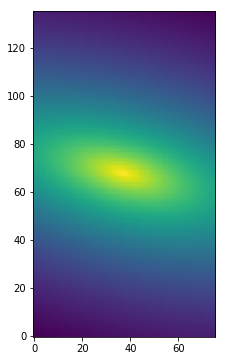

In [67]:
fg=plt.figure(figsize=(8,6))
ax = plt.gca()
ax.imshow(zs[0], origin='lower')

In [209]:
my_times = eq.event_date_float + numpy.arange(0., 100., 1.)
#
fname = 'global_test.h5'
f#name2 = 'global_toy2.h5'
#
h5_global = nETAS.create_netas_hdf5(fname_out=fname, times=my_times, times_to=None,
                              lats=numpy.arange(-90., 90., .1), lons=numpy.arange(-180., 180., .1))

#h5_global_1d = nETAS.create_netas_hdf5_1D(fname_out=fname2, times=my_times, times_to=None,
#                              lats=numpy.arange(-90., 90., .1), lons=numpy.arange(-180., 180., .1))

#ary_output = numpy.zeros((len(my_times), 1800, 3600))
#
with h5py.File(fname, 'r') as fin:
    print('*** nETAS.shape', fin['nETAS'].shape, numpy.prod(fin['nETAS'].shape))
#with h5py.File(fname2, 'r') as fin:
#    print('*** nETAS_1d.shape', fin['nETAS'].shape)
#

# lay down some earthquakes...
NC2 = nETAS.NETAS_collector(h5_file=fname, catalog=mycat, times=my_times)
#
print(NC2.d_lat)

*** nETAS.shape (100, 1800, 3600) 648000000
0.1


** h5 file written, -2000-0 / 6109
*** zs:  (100, 1, 1)
** h5 file written, 0-2000 / 6109
*** zs:  (100, 1, 1)
** h5 file written, 2000-4000 / 6109
*** zs:  (100, 1, 1)
** h5 file written, 4000-6000 / 6109
*** zs:  (100, 1, 1)


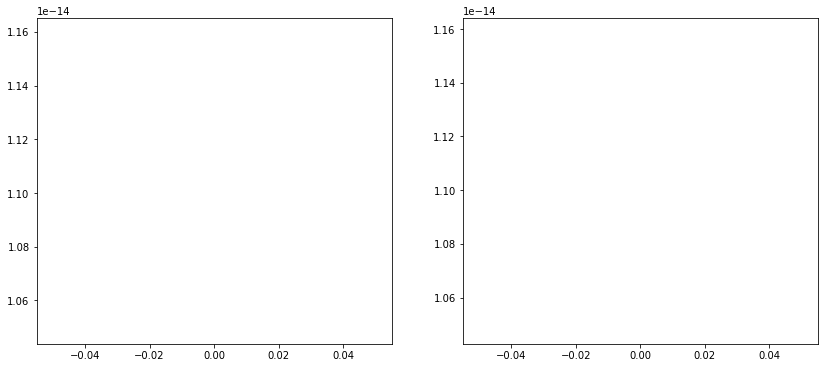

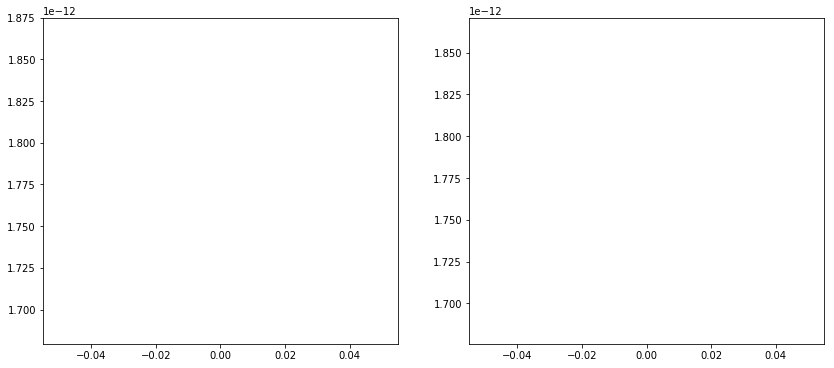

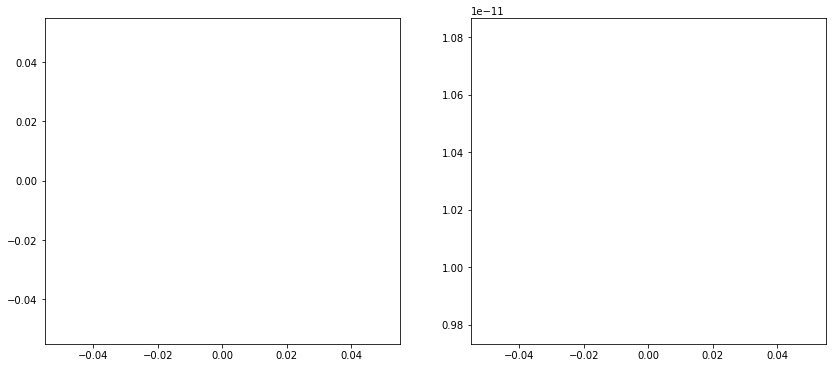

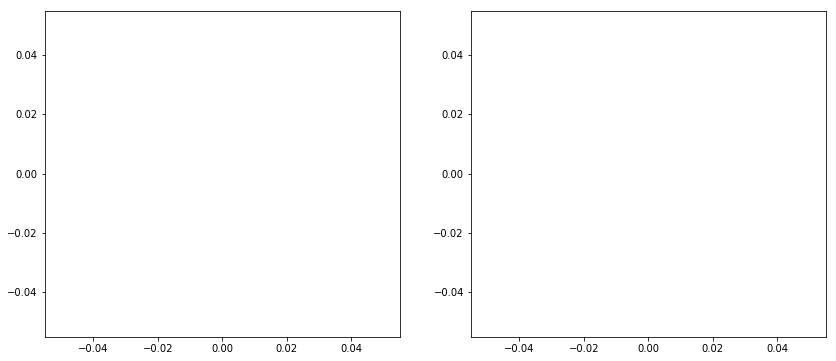

In [210]:
zz = NC2.compute_nETAS(batch_size=2000)



***  394430


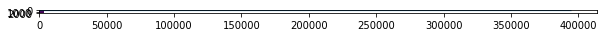

<Figure size 720x576 with 0 Axes>

In [200]:
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
#
with h5py.File(fname, 'r') as fin:
    print('*** ', len((fin['nETAS'][0])[fin['nETAS'][0]>0.].ravel()))
    ax.imshow(fin['nETAS'][0])
    #
    fg=plt.figure(figsize=(10,8))
    ax.plot(numpy.log((fin['nETAS'][0])[fin['nETAS'][0]>0.].ravel()))

In [188]:
100*1800*3600


648000000